# Running ParlaSpeechHR Models
Custom kenLM model working! ## main trick for unicode decode errors, is to change encoding from None to "utf-8" !!! 

Makes both base and base+lm models, runs transcriptions, calculates WER and CER, plots WER and CER plus maybe some stats.

## [0] Start here:

In [19]:
make_model = "both" ## Options "non" for just acoustic model, "lm" for acoustic+LM, and "both" for both"

google_colabbing = False
debug_printing = True
clear_lm_print = False

testing_asr = True # if False, cuts audio into chunks
shuffle_transcript = True

In [20]:
work_version_num = 5.0
word_version_preffix = ""
word_version_suffix = ""
work_version = f"{word_version_preffix}v{work_version_num}{word_version_suffix}"

print(work_version)

v5.0


## [INFO ABOUT MACHINE]

In [7]:
### NEED TO REINSTALL PYTORCH WITH CUDA ENABLED AND TRY AGAIN I GUESS

In [8]:
import cpuinfo

info = cpuinfo.get_cpu_info()

print("Processor:", info["brand_raw"])
print("Architecture:", info["arch"])
print("Cores:", info["count"])

Processor: 11th Gen Intel(R) Core(TM) i5-11600 @ 2.80GHz
Architecture: X86_64
Cores: 12


In [9]:
#!pip install pyopencl

import pyopencl as cl

# Get a list of all available platforms
platforms = cl.get_platforms()

for platform in platforms:
    print(f"Platform: {platform.name}")
    print(f"Vendor: {platform.vendor}")
    print(f"Version: {platform.version}")

    # Get a list of all available devices for the current platform
    devices = platform.get_devices()
    for device in devices:
        print(f"\nDevice: {device.name}")
        print(f"Type: {cl.device_type.to_string(device.type)}")
        print(f"Max Compute Units: {device.max_compute_units}")
        print(f"Max Work Item Dimensions: {device.max_work_item_dimensions}")
        print(f"Max Work Group Size: {device.max_work_group_size}")
        print(f"Max Clock Frequency: {device.max_clock_frequency} MHz")
        print(f"Global Memory Size: {device.global_mem_size / (1024 ** 3):.2f} GB")
        print(f"Local Memory Size: {device.local_mem_size / 1024:.2f} KB")
        print(f"Max Memory Allocation Size: {device.max_mem_alloc_size / (1024 ** 3):.2f} GB")
        print(f"OpenCL Version: {device.opencl_c_version}")
        print(f"Driver Version: {device.driver_version}")


Platform: NVIDIA CUDA
Vendor: NVIDIA Corporation
Version: OpenCL 1.2 CUDA 11.1.96

Device: GeForce GTX 760
Type: ALL | GPU
Max Compute Units: 6
Max Work Item Dimensions: 3
Max Work Group Size: 1024
Max Clock Frequency: 1150 MHz
Global Memory Size: 4.00 GB
Local Memory Size: 48.00 KB
Max Memory Allocation Size: 1.00 GB
OpenCL Version: OpenCL C 1.2 
Driver Version: 456.71
Platform: Intel(R) OpenCL HD Graphics
Vendor: Intel(R) Corporation
Version: OpenCL 3.0 

Device: Intel(R) UHD Graphics 750
Type: ALL | GPU
Max Compute Units: 32
Max Work Item Dimensions: 3
Max Work Group Size: 256
Max Clock Frequency: 1300 MHz
Global Memory Size: 6.32 GB
Local Memory Size: 64.00 KB
Max Memory Allocation Size: 3.16 GB
OpenCL Version: OpenCL C 1.2 
Driver Version: 30.0.101.1273
Platform: Intel(R) OpenCL
Vendor: Intel(R) Corporation
Version: OpenCL 3.0 WINDOWS

Device: 11th Gen Intel(R) Core(TM) i5-11600 @ 2.80GHz
Type: ALL | CPU
Max Compute Units: 12
Max Work Item Dimensions: 3
Max Work Group Size: 8192
M

CPU VERSION:
Device: 11th Gen Intel(R) Core(TM) i5-11600 @ 2.80GHz
Type: ALL | CPU
Max Compute Units: 12
Max Work Item Dimensions: 3
Max Work Group Size: 8192
Max Clock Frequency: 2800 MHz
Global Memory Size: 15.80 GB
Local Memory Size: 32.00 KB
Max Memory Allocation Size: 7.90 GB
OpenCL Version: OpenCL C 3.0 
Driver Version: 2023.16.6.0.28_042959

In [3]:
!pip show torch
!pip show torchvision
!pip show torchaudio

Name: torch
Version: 2.3.1
Summary: Tensors and Dynamic neural networks in Python with strong GPU acceleration
Home-page: https://pytorch.org/
Author: PyTorch Team
Author-email: packages@pytorch.org
License: BSD-3
Location: C:\Users\Public\anaconda3\envs\PyPhon\Lib\site-packages
Requires: filelock, fsspec, jinja2, mkl, networkx, sympy, typing-extensions
Required-by: accelerate, optimum, sentence-transformers, torchaudio, torchvision


Name: torchvision
Version: 0.18.1
Summary: image and video datasets and models for torch deep learning
Home-page: https://github.com/pytorch/vision
Author: PyTorch Core Team
Author-email: soumith@pytorch.org
License: BSD
Location: C:\Users\Public\anaconda3\envs\PyPhon\Lib\site-packages
Requires: numpy, pillow, torch
Required-by: sentence-transformers


Name: torchaudio
Version: 2.3.1
Summary: An audio package for PyTorch
Home-page: https://github.com/pytorch/audio
Author: Soumith Chintala, David Pollack, Sean Naren, Peter Goldsborough, Moto Hira, Caroline Chen, Jeff Hwang, Zhaoheng Ni, Xiaohui Zhang
Author-email: soumith@pytorch.org
License: 
Location: C:\Users\Public\anaconda3\envs\PyPhon\Lib\site-packages
Requires: torch
Required-by: 


In [7]:
import subprocess
import shutil

def command_exists(command):
    return shutil.which(command) is not None

def get_pip_version(package_name):
    if not command_exists("pip"):
        return f"pip is not installed on this system."
    result = subprocess.run(["pip", "show", package_name], capture_output=True, text=True)
    for line in result.stdout.splitlines():
        if line.startswith("Version:"):
            return line.split(" ")[-1]
    return f"{package_name} not found via pip."

def get_conda_version(package_name):
    if not command_exists("conda"):
        return f"conda is not installed on this system."
    result = subprocess.run(["conda", "list", package_name], capture_output=True, text=True)
    for line in result.stdout.splitlines():
        if line.startswith(package_name):
            return line.split()[1]
    return f"{package_name} not found via conda."

# Get versions using pip
torch_version = get_pip_version("torch")
torchvision_version = get_pip_version("torchvision")
torchaudio_version = get_pip_version("torchaudio")

print(f"torch version (pip): {torch_version}")
print(f"torchvision version (pip): {torchvision_version}")
print(f"torchaudio version (pip): {torchaudio_version}")

# Get versions using conda
torch_version_conda = get_conda_version("torch")
torchvision_version_conda = get_conda_version("torchvision")
torchaudio_version_conda = get_conda_version("torchaudio")

print(f"torch version (conda): {torch_version_conda}")
print(f"torchvision version (conda): {torchvision_version_conda}")
print(f"torchaudio version (conda): {torchaudio_version_conda}")


torch version (pip): torch not found via pip.
torchvision version (pip): torchvision not found via pip.
torchaudio version (pip): torchaudio not found via pip.
torch version (conda): torch not found via conda.
torchvision version (conda): torchvision not found via conda.
torchaudio version (conda): torchaudio not found via conda.


In [126]:
import torch


if torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 3.7:
    device = torch.device("cuda:0")  # Use GPU
    print("Using GPU:", torch.cuda.get_device_name(0))
    print("CUDA available:", torch.cuda.is_available())
    print("CUDA version:", torch.version.cuda)
    print("cuDNN version:", torch.backends.cudnn.version())
    print("Device Name:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")  # Use CPU
    print("CUDA not available or GPU is too old.")
    print(f"device set to: CPU ({device})")
    

CUDA not available or GPU is too old.
device set to: CPU (cpu)


## [1] Install all required packages

In [134]:
#!pip install ipython
from IPython.display import clear_output

try:
    import transformers
    print("transformers: All good.")
except ImportError:
    !pip install transformers
    print("transformers: Installed.")

try:
    import pydub
    print("pydub: All good.")
except ImportError:
    !pip install pydub
    print("pydub: Installed.")

try:
    import torch
    print("torch: All good.")
except ImportError:
    !conda install pytorch torchvision torchaudio cpuonly -c pytorch
    # !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu

try:
    import torchaudio
    print("torchaudio: All good.")
except ImportError:
    !pip install torchaudio
    print("torchaudio: Installed.")

try:
    import pyctcdecode
    print("pyctcdecode: All good.")
except ImportError:
    !pip install pyctcdecode
    print("pyctcdecode: Installed.")

try:
    import jiwer
    print("jiwer: All good.")
except ImportError:
    !pip install jiwer
    print("jiwer: Installed.")

try:
    import nltk
    nltk.download('punkt')
    print("nltk: All good.")
except ImportError:
    !pip install nltk
    print("nltk: Installed.")

try:
    from fuzzywuzzy import fuzz
    print("fuzzywuzzy: All good.")
except ImportError:   
    !pip install fuzzywuzzy
    print("fuzzywuzzy: Installed.")

#clear_output(wait=True) # clean the mess
print(f"All good. Every essential package is present to make the code work.")

transformers: All good.
pydub: All good.
torch: All good.
torchaudio: All good.
pyctcdecode: All good.
jiwer: All good.
nltk: All good.
fuzzywuzzy: All good.
All good. Every essential package is present to make the code work.


[nltk_data] Downloading package punkt to C:\Users\Mr Cab
[nltk_data]     Driver\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
try:
    import kenlm
    print(f"All good. kenlm is present to make the LM model.")
except ImportError:
    !pip install https://github.com/kpu/kenlm/archive/master.zip # requires runtime restart
    import os
    os.kill(os.getpid(), 9) # restart automatically

All good. kenlm is present to make the LM model.


## Generating shit for kenLM
* got to [7]to gen audio_transcriptions!

In [3]:
# PATHS SETUP
import os

# Path to your input JSONL file
input_jsonl_path = r"D:\ParlaSpeech-HR.v1.0\ParlaSpeech-HR.v1.0.jsonl"

# Path to output JSON file for lmplz
save_json_name = f"kenlm_lmplz_to_arpa_{work_version}.json"
save_txt_name = f"kenlm_lmplz_to_arpa_{work_version}.txt"

output_json_path = r"D:\ParlaSpeech-HR.v1.0"
output_txt_path = output_json_path

output_json_path = os.path.join(output_json_path, save_json_name)
output_txt_path = os.path.join(output_txt_path, save_txt_name)

In [6]:
# Because the newest version if messed up
#conda install -c conda-forge transformers==4.14.1 tokenizers==0.13.3 -y

In [8]:
%%time

import json
import re

# Define characters and patterns
unknown_word = r'[,?.!\-\;\:"“%‘”�—’…–]—½–¸€π¾¼ö’̊′‰°„´“ôţ'
unknown_chars = ['<', '>', '#']

data_for_lm = []

# Regex pattern to match any character not in the allowed characters
symbol_pattern = re.compile(unknown_word)

# Read JSONL file and process each line
with open(input_jsonl_path, 'r', encoding='utf-8') as jsonl_file:
    for line in jsonl_file:
        data = json.loads(line.strip())
        if 'norm_words' in data:
            norm_words = data['norm_words']
            # Join words into a single string
            sentence = " ".join(norm_words)
            # Remove symbols not allowed
            sentence = re.sub(unknown_word, "", sentence.lower())
            for char in unknown_chars:
                sentence = sentence.replace(char, '')
            # Add to list
            data_for_lm.append(sentence)

# Save cleaned data to JSON
with open(output_json_path, 'w', encoding='utf-8') as json_file:
    json.dump(data_for_lm, json_file, indent=4, ensure_ascii=True)  # Ensure_ascii=False to keep Unicode characters as literals SO DONT DO IT 

print(f"JSON file for lmplz created successfully: {output_json_path}")

# Save cleaned data to TXT
with open(output_txt_path, 'w', encoding='utf-8') as txt_file:
    txt_file.write("\n".join(data_for_lm))

print(f"TXT file created successfully: {output_txt_path}")



# Set the path to your .ARPA file
ngram_name = f"ngram_{work_version}.arpa"
path_to_ngram =  r"D:\ParlaSpeech-HR.v1.0"
path_to_ngram = os.path.join(path_to_ngram, ngram_name)

print(f"ngram.arpa path and name set to: \n{path_to_ngram}\n")
# now execute the lmplz plz

JSON file for lmplz created successfully: D:\ParlaSpeech-HR.v1.0\kenlm_lmplz_to_arpa_v4.4.json
TXT file created successfully: D:\ParlaSpeech-HR.v1.0\kenlm_lmplz_to_arpa_v4.4.txt
ngram.arpa path and name set to: 
D:\ParlaSpeech-HR.v1.0\ngram_v4.4.arpa

CPU times: total: 10.2 s
Wall time: 10.3 s


In [9]:
## JSON FILE NOW CONTAINS \uxxxx unicode escapes 

In [11]:
lines_to_print = 10  # Adjust the number of lines to print

with open(output_txt_path, 'r', encoding='utf-8') as txt_file:
    for i, line in enumerate(txt_file):
        if i >= lines_to_print:
            break
        print(line, end='')

primjeni željezničkih paketa kojima se postupno i nezaustavljivo stvara jedinstveni europski željeznički prostor provedba ovog zakona nema financijski utjecaj na državni proračun hvala lijepo zahvaljujem ministru imamo sedam replika prvi je kolega kirin izvolite
km i distribuira ih na nekih dvije tisuće šesto priključaka zahvaća još rubne dijelove nekih drugih lokalnih jedinica mogu reć da ima samo osam zaposlenih ukupno prihode u iznosu od četiriosam milijuna kuna vrijednost imovine društva četrdeset pet milijuna kuna evo dvije tisuće četrnaest do dvije tisuće osamnaest je realizirano je ukupno
se pozivati na to kao da je on jedini bogom dan da spasi ovu hrvatsku a svi ostali ništa ne razumiju pa se tako razbacaju i sa riječima i sa time da ne respektira šta građani erha misle o ovom konkretnom slučaju ne respektira o tome što misle da on krivo vodi hrvatsku
međutim s druge strane moramo znati da vrlo često postoje snažni javni opći interesi za izgradnju infrastrukturnih objekata za i

In [8]:
## CLEANS GOOD

import re

# Define the function to check for Unicode escape sequences
def contains_unicode_escapes(text):
    return bool(re.search(r'\\u[0-9A-Fa-f]{4}', text))

# Define the lmplz vocabulary
lmplz_vocab = set(' abcdefghijklmnopqrstuvwxyzäüćčđšžӧ1234567890.')

# Path to the input text file
kenlm_input_txt_path = r"D:\ParlaSpeech-HR.v1.0\kenlm_lmplz_to_arpa_v4.4.txt"

# Counters for the lines with issues
unicode_escape_count = 0
out_of_vocab_count = 0

# Limit the number of lines to print for each type of issue
print_limit = 2

# Track if we reached the print limit
unicode_printed = 0
out_of_vocab_printed = 0

# List to store valid lines
valid_lines = []

# Process the text file
with open(kenlm_input_txt_path, 'r', encoding='utf-8') as file:
    for line in file:
        line = line.strip()
        has_unicode_escapes = contains_unicode_escapes(line)
        has_out_of_vocab_chars = any(char not in lmplz_vocab for char in line)

        if has_unicode_escapes:
            unicode_escape_count += 1
            if unicode_printed < print_limit:
                print(f"Unicode escape sequence found in line: {line}")
                unicode_printed += 1

        if has_out_of_vocab_chars:
            out_of_vocab_count += 1
            if out_of_vocab_printed < print_limit:
                print(f"Out of vocab character found in line: {line}")
                out_of_vocab_printed += 1

        if not has_unicode_escapes and not has_out_of_vocab_chars:
            valid_lines.append(line)

print(f"\nTotal lines with Unicode escape sequences: {unicode_escape_count}")
print(f"Total lines with out of vocab characters: {out_of_vocab_count}")

# Write valid lines back to the same file
with open(kenlm_input_txt_path, 'w', encoding='utf-8') as file:
    for line in valid_lines:
        file.write(line + '\n')

print(f"Cleaned text file saved to: {kenlm_input_txt_path}")



Total lines with Unicode escape sequences: 0
Total lines with out of vocab characters: 0
Cleaned text file saved to: D:\ParlaSpeech-HR.v1.0\kenlm_lmplz_to_arpa_v4.4.txt


In [9]:
def has_bom(file_path):
    with open(file_path, 'rb') as f:
        first_bytes = f.read(4)  # Read the first 4 bytes (BOMs are usually within first 2-4 bytes)
        if first_bytes.startswith(b'\xef\xbb\xbf'):  # UTF-8 BOM
            return True
        elif first_bytes.startswith(b'\xff\xfe') or first_bytes.startswith(b'\xfe\xff'):  # UTF-16 BOMs
            return True
        else:
            return False
            
def remove_bom(file_path):
    # Read the entire file
    with open(file_path, 'rb') as f:
        content = f.read()
    
    # Check and remove BOM if present
    if content.startswith(b'\xef\xbb\xbf'):  # UTF-8 BOM
        content = content[3:]  # Remove the first 3 bytes
    elif content.startswith(b'\xff\xfe') or content.startswith(b'\xfe\xff'):  # UTF-16 BOMs
        content = content[2:]  # Remove the first 2 bytes (assuming little-endian)
    
    # Write back to the file
    with open(file_path, 'wb') as f:
        f.write(content)


In [10]:
file_path = r"D:\ParlaSpeech-HR.v1.0\kenlm_lmplz_to_arpa_v4.4.txt"

if has_bom(file_path):
    remove_bom(file_path)
    print("BOM removed successfully.")
else:
    print("No BOM found.")


No BOM found.


In [13]:
%%time

import os
## seems to work now! about 9mins
# Set the path to your .ARPA file
ngram_name = f"ngram_{work_version}.arpa"
path_to_ngram =  r"D:\ParlaSpeech-HR.v1.0"
path_to_ngram = os.path.join(path_to_ngram, ngram_name)

print(f"ngram.arpa path and name set to: \n{path_to_ngram}\n")

# IF TAKING TXT AFTER PREVIOUS CLEANING
output_txt_path = kenlm_input_txt_path


lmplz_path = r"D:/ASR/kenlm/bin/Debug/lmplz"

lmplz_args = f" -o 5 -S 80% --skip_symbols < {output_txt_path} > {path_to_ngram}"

lmplz_execute = lmplz_path + lmplz_args


print(f"\nLoading data from: \n{output_txt_path}\n")


print(f"\nExecuting lmplz CMD: \n{lmplz_execute}\n")

#os.system(lmplz_execute)
print(f"\nExecution complete: \n{path_to_ngram} \n")

ngram.arpa path and name set to: 
D:\ParlaSpeech-HR.v1.0\ngram_v4.4.arpa


Loading data from: 
D:\ParlaSpeech-HR.v1.0\kenlm_lmplz_to_arpa_v4.4.txt


Executing lmplz CMD: 
D:/ASR/kenlm/bin/Debug/lmplz -o 5 -S 80% --skip_symbols < D:\ParlaSpeech-HR.v1.0\kenlm_lmplz_to_arpa_v4.4.txt > D:\ParlaSpeech-HR.v1.0\ngram_v4.4.arpa


Execution complete: 
D:\ParlaSpeech-HR.v1.0\ngram_v4.4.arpa 

CPU times: total: 0 ns
Wall time: 0 ns


### D:/ASR/kenlm/bin/Debug/lmplz -o 5 -S 80% < D:\ParlaSpeech-HR.v1.0\kenlm_lmplz_to_arpav_4.2.txt > D:\ParlaSpeech-HR.v1.0\ngram_v4.2.arpa

### xx Make attrs.json, unigram.txt

In [ ]:
import json
from collections import defaultdict

arpa_model_path = r"D:\ParlaSpeech-HR.v1.0\ngram_v4.4.arpa"

# save files to
unigram_txt_path = r"D:\ParlaSpeech-HR.v1.0\unigrams4.txt"


# Save attributes to JSON file
with open(attrs_json_path, 'w', encoding='utf-8') as f:
    json.dump(attributes, f, indent=2)

print(f"Attributes saved to {attrs_json_path}")

# Extract unigrams to text file (unigram.txt)
def extract_unigrams(arpa_file):
    unigrams = defaultdict(float)
    with open(arpa_file, 'r', encoding='utf-8') as f:
        for line in f:
            if line.startswith('-'):
                parts = line.strip().split()
                if len(parts) >= 2:
                    prob = float(parts[0])
                    word = parts[1]
                    unigrams[word] = prob
    return unigrams

unigrams = extract_unigrams(arpa_model_path)

# Save unigrams to text file
with open(unigram_txt_path, 'w', encoding='utf-8') as f:
    for word, prob in unigrams.items():
        f.write(f"{prob}\t{word}\n")

print(f"Unigrams saved to {unigram_txt_path}")

In [ ]:
### maybe worth a try
import subprocess

# Define your command
command = lmplz_execute

# Execute the command and capture the output
result = subprocess.run(command, shell=True, capture_output=True, text=True)

# Check if the command executed successfully
if result.returncode == 0:
    # Print the output in Jupyter Lab cell
    print(result.stdout)
else:
    # Handle the case where the command failed, if needed
    print("Command execution failed")


### vrtimo ken lm LanguageModel

In [3]:
import kenlm

# lm_path = r"D:\ParlaSpeech-HR.v1.0\ngram_v4.1_kenlm.bin"
lm_path = r"D:\ParlaSpeech-HR.v1.0\ngram_v4.4.arpa"

lm = kenlm.LanguageModel(lm_path)

sentence = "što radiš ti to tamo a"
print(lm.score(sentence))

-18.274045944213867


In [4]:
words = ['<s>'] + sentence.split() + ['</s>']
for i, (prob, length, oov) in enumerate(lm.full_scores(sentence)):
  print(f'{prob} {length}: {" ".join(words[i+2-length:i+2])}')
  if oov:
    print(f'\t"{words[i+1]}" is an OOV')

for w in words:
  if not w in lm:
    print(f'"{w}" is an OOV')

-2.0787603855133057 2: <s> što
-4.54342794418335 2: što radiš
-2.01373291015625 2: radiš ti
-2.1233317852020264 2: ti to
-3.3811776638031006 2: to tamo
-2.154578924179077 2: tamo a
-1.9790356159210205 2: a </s>


In [5]:
import sys
print(sys.getdefaultencoding())


utf-8


In [2]:
input_file = r"D:\ParlaSpeech-HR.v1.0\unigrams2.txt"
output_file = r"D:\ParlaSpeech-HR.v1.0\unigrams2esc.txt"

# Function to convert literal characters to escape sequences
def convert_to_escape_sequences(text):
    return ''.join([f'\\u{ord(char):04x}' for char in text])

# Open input and output files
with open(input_file, 'r', encoding='utf-8') as fin, open(output_file, 'w', encoding='utf-8') as fout:
    for line in fin:
        converted_line = convert_to_escape_sequences(line.strip())
        fout.write(converted_line + '\n')

print(f"Conversion complete. Output written to {output_file}")


Conversion complete. Output written to D:\ParlaSpeech-HR.v1.0\unigrams2esc.txt


In [6]:
from transformers import AutoProcessor

load_lm_proc = r"D:\ASR\ParlaspeechHR\wav2vec2-large-slavic-hr"

processor1 = AutoProcessor.from_pretrained(load_lm_proc)
print("loaded proc")

C:\Users\Public\anaconda3\envs\PyPhon\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


loaded proc


C:\Users\Public\anaconda3\envs\PyPhon\Lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [7]:
vocab_dict = processor1.tokenizer.get_vocab()
sorted_vocab_dict = {k.lower(): v for k, v in sorted(vocab_dict.items(), key=lambda item: item[1])}
print("got vocab")

print(f"vocab: {sorted_vocab_dict.keys()}")

got vocab
vocab: dict_keys([' ', '<pad>', '[unk]', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ä', 'ü', 'ć', 'č', 'đ', 'š', 'ž', 'ӧ', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '.', '<s>', '</s>'])


In [6]:
unigrams_raw = r"D:\ParlaSpeech-HR.v1.0\kenlm_lmplz_to_arpa_v4.2.txt"
#unigrams_raw = r"D:\ASR\ParlaspeechHR\unigrams_raw.txt"

# Function to read and process unigrams_raw.txt
def read_unigrams(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        # Read all lines and split into words/tokens
        unigrams = file.read().strip().split()
        return unigrams

# Read and process unigrams_raw.txt
unigrams = read_unigrams(unigrams_raw)

# Initialize an empty dictionary to store character counts
char_count = {}

# Count unique characters in unigrams
for word in unigrams:
    for char in word:
        if char in char_count:
            char_count[char] += 1
        else:
            char_count[char] = 1
            
if debug_printing:
    # Print the character counts
    for char, count in char_count.items():
        print(f"Character '{char}' occurs {count} times.")

# Initialize a list to store characters not in sorted_vocab_dict
unknown_chars = []

# Check and store characters not in sorted_vocab_dict
for char in char_count.keys():
    if char not in sorted_vocab_dict:
        unknown_chars.append(char)

print("unknown_chars:", unknown_chars)
unknown_word = ''.join(unknown_chars)
print("Unknown word:", unknown_word)

NameError: name 'debug_printing' is not defined

D:\ASR\kenlm\bin\Debug\build_binary D:\ParlaSpeech-HR.v1.0\ngram_v4.2.arpa D:\ParlaSpeech-HR.v1.0\ngram_v4.2.bin

In [4]:
from transformers import AutoProcessor

load_lm_proc = r"D:\ASR\ParlaspeechHR\wav2vec2-large-slavic-hr"

processor1 = AutoProcessor.from_pretrained(load_lm_proc)
print("loaded proc")

vocab_dict = processor1.tokenizer.get_vocab()
sorted_vocab_dict = {k.lower(): v for k, v in sorted(vocab_dict.items(), key=lambda item: item[1])}
print("got vocab")

print(f"\nvocab: \n{sorted_vocab_dict.keys()}")

C:\Users\Public\anaconda3\envs\PyPhon\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


loaded proc
got vocab

vocab: 
dict_keys([' ', '<pad>', '[unk]', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ä', 'ü', 'ć', 'č', 'đ', 'š', 'ž', 'ӧ', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '.', '<s>', '</s>'])


C:\Users\Public\anaconda3\envs\PyPhon\Lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [5]:
%%time

# Treba otprilike 1min30s

import codecs
from pyctcdecode import build_ctcdecoder
from pyctcdecode.language_model import load_unigram_set_from_arpa as original_load_unigram_set_from_arpa

# Force utf-8 encoding with this wrapper:
def load_unigram_set_from_arpa_utf8(arpa_path):
    with codecs.open(arpa_path, 'r', encoding='utf-8') as f:
        start_1_gram = False
        unigrams = set()
        for line in f:
            line = line.strip()
            if line == "\\1-grams:":
                start_1_gram = True
            elif line == "":
                start_1_gram = False
            elif start_1_gram:
                parts = line.split()
                if len(parts) >= 2:
                    unigrams.add(parts[1])
        return unigrams

# Use the modified function for loading unigrams
def build_ctcdecoder_utf8(labels, kenlm_model_path, unigrams=None, alpha=0.5, beta=1.0, unk_score_offset=-10.0, lm_score_boundary=True):
    if unigrams is None and kenlm_model_path is not None:
        if kenlm_model_path.endswith(".arpa"):
            unigrams = load_unigram_set_from_arpa_utf8(kenlm_model_path)
        else:
            logger.warning(
                "Unigrams not provided and cannot be automatically determined from LM file (only "
                "arpa format). Decoding accuracy might be reduced."
            )
    return build_ctcdecoder(labels, kenlm_model_path, unigrams, alpha, beta, unk_score_offset, lm_score_boundary)


# Define paths
darpa = r"D:\ParlaSpeech-HR.v1.0\ngram_v4.4.arpa"

DEFAULT_ALPHA = 0.5
DEFAULT_BETA = 0.5
DEFAULT_UNK_LOGP_OFFSET = -1.0
DEFAULT_SCORE_LM_BOUNDARY = True


# Build the decoder with labels, kenlm_model_path, and unigrams ## SUPER IMPORTANT TO USE WRAPPER FUNCTION
decoder_arpa = build_ctcdecoder_utf8(
                                    labels=list(sorted_vocab_dict.keys()),
                                    kenlm_model_path=darpa,
                                    alpha=DEFAULT_ALPHA,
                                    beta=DEFAULT_BETA,
                                    unk_score_offset=DEFAULT_UNK_LOGP_OFFSET,
                                    lm_score_boundary=DEFAULT_SCORE_LM_BOUNDARY,
)

print(f"\ndecoder_arpa of the lm type is here\n")


Found entries of length > 1 in alphabet. This is unusual unless style is BPE, but the alphabet was not recognized as BPE type. Is this correct?



decoder_arpa of the lm type is here

CPU times: total: 1min 28s
Wall time: 1min 29s


### D:\ASR\kenlm\bin\Debug\build_binary D:\ParlaSpeech-HR.v1.0\ngram_v4.4.arpa D:\ParlaSpeech-HR.v1.0\ngram_v4.4.bin

In [22]:
%%time

### BIN ####

# Treba otprilike

import codecs
from pyctcdecode import build_ctcdecoder
from pyctcdecode.language_model import load_unigram_set_from_arpa as original_load_unigram_set_from_arpa
from typing import List, Optional, Collection
import logging

# Configure logging (set level and handlers as needed)
logging.basicConfig(level=logging.INFO)  # Adjust level as needed
logger = logging.getLogger(__name__)  # Create logger instance for your module



# Function to load unigrams from a text file
def load_unigrams_from_txt(txt_file_path: str) -> List[str]:
    with codecs.open(txt_file_path, 'r', encoding='utf-8') as f:
        unigrams = [line.strip() for line in f if line.strip()]
    return unigrams

# Modified build_ctcdecoder_utf8 function
def build_ctcdecoder_utf8(labels: List[str], kenlm_model_path: Optional[str] = None,
                          unigrams: Optional[Collection[str]] = None,
                          unigrams_txt_file: Optional[str] = None,
                          alpha: float = 0.5, beta: float = 1.0,
                          unk_score_offset: float = -10.0,
                          lm_score_boundary: bool = True):

    # Load unigrams from file if not provided
    if unigrams is None and unigrams_txt_file is not None:
        unigrams = load_unigrams_from_txt(unigrams_txt_file)

    # Load unigrams from ARPA if kenlm_model_path is provided and unigrams are still None
    if unigrams is None and kenlm_model_path is not None:
        if kenlm_model_path.endswith(".arpa"):
            unigrams = load_unigram_set_from_arpa_utf8(kenlm_model_path)
        else:
            logger.warning(
                "Unigrams not provided and cannot be automatically determined from LM file (only "
                "arpa format). Decoding accuracy might be reduced."
            )

    return build_ctcdecoder(labels, kenlm_model_path, unigrams, alpha, beta, unk_score_offset, lm_score_boundary)


# Define paths
dbin = r"D:\ParlaSpeech-HR.v1.0\ngram_v4.4.bin"

DEFAULT_ALPHA = 0.5
DEFAULT_BETA = 1.0
DEFAULT_UNK_LOGP_OFFSET = -10.0
DEFAULT_SCORE_LM_BOUNDARY = True

unigrams_txt_file = r"D:\ParlaSpeech-HR.v1.0\unigrams_v4.4.txt"  # Specify the path to save unigrams
unigrams = load_unigrams_from_txt(unigrams_txt_file)


# Build the decoder with labels, kenlm_model_path, and unigrams
decoder_bin = build_ctcdecoder_utf8(
                                    labels=list(sorted_vocab_dict.keys()),
                                    kenlm_model_path=dbin,
                                    unigrams=unigrams,
                                    alpha=DEFAULT_ALPHA,
                                    beta=DEFAULT_BETA,
                                    unk_score_offset=DEFAULT_UNK_LOGP_OFFSET,
                                    lm_score_boundary=DEFAULT_SCORE_LM_BOUNDARY,
)

print(f"\ndecoder_bin of the lm type is here\n")

INFO:pyctcdecode.alphabet:Alphabet determined to be of regular style.
INFO:pyctcdecode.alphabet:Found <pad> in vocabulary, interpreted as a CTC blank token, substituting with .
INFO:pyctcdecode.alphabet:Found [unk] in vocabulary, interpreting as unknown token, substituting with ⁇.



decoder_bin of the lm type is here

CPU times: total: 2.16 s
Wall time: 2.16 s


## def load_pretrained_utf8 - Nužno zlo

In [25]:
from transformers import PreTrainedTokenizer, SequenceFeatureExtractor, ProcessorMixin, requires_backends, AutoFeatureExtractor, Wav2Vec2CTCTokenizer, Wav2Vec2ProcessorWithLM
from torch import nn
import os

class Wav2Vec2ProcessorWithLM_UTF8(Wav2Vec2ProcessorWithLM, nn.Module):

    feature_extractor_class = "AutoFeatureExtractor"
    tokenizer_class = "Wav2Vec2CTCTokenizer"

    @classmethod
    def from_pretrained_utf8(cls, pretrained_model_name_or_path, **kwargs):
        requires_backends(cls, "pyctcdecode")
        from pyctcdecode import BeamSearchDecoderCTC

        feature_extractor, tokenizer, decoder = super().from_pretrained(pretrained_model_name_or_path, **kwargs)


        if os.path.isdir(pretrained_model_name_or_path) or os.path.isfile(pretrained_model_name_or_path):
            unigram_encoding = kwargs.get("unigram_encoding", "utf-8")
            decoder = BeamSearchDecoderCTC.load_from_dir(pretrained_model_name_or_path, unigram_encoding)
        else:
            kwargs.pop("_from_auto", None)
            kwargs.pop("trust_remote_code", None)

            language_model_filenames = os.path.join(BeamSearchDecoderCTC._LANGUAGE_MODEL_SERIALIZED_DIRECTORY, "*")
            alphabet_filename = BeamSearchDecoderCTC._ALPHABET_SERIALIZED_FILENAME
            allow_patterns = [language_model_filenames, alphabet_filename]

            decoder = BeamSearchDecoderCTC.load_from_hf_hub(
                pretrained_model_name_or_path, allow_patterns=allow_patterns, **kwargs
            )

        # set language model attributes
        for attribute in ["alpha", "beta", "unk_score_offset", "score_boundary"]:
            value = kwargs.pop(attribute, None)
            if value is not None:
                cls._set_language_model_attribute(decoder, attribute, value)

        missing_decoder_tokens = cls.get_missing_alphabet_tokens(decoder, tokenizer)
        if len(missing_decoder_tokens) > 0:
            raise ValueError(
                f"The tokens {missing_decoder_tokens} are defined in the tokenizer's "
                "vocabulary, but not in the decoder's alphabet. "
                f"Make sure to include {missing_decoder_tokens} in the decoder's alphabet."
            )

        return cls(feature_extractor=feature_extractor, tokenizer=tokenizer, decoder=decoder)

    @staticmethod
    def _get_arguments_from_pretrained(pretrained_model_name_or_path, **kwargs):
        feature_extractor = SequenceFeatureExtractor.from_pretrained(pretrained_model_name_or_path, **kwargs)
        tokenizer = PreTrainedTokenizer.from_pretrained(pretrained_model_name_or_path, **kwargs)
        return feature_extractor, tokenizer


## Good DecoderCTC_UTF8 yo

In [24]:
import os
import shutil
from transformers import Wav2Vec2ProcessorWithLM

class BeamSearchDecoderCTC_UTF8:
    def __init__(self, original_decoder):
        self._decoder = original_decoder
    
    def save_to_dir_utf8(self, filepath):
        """Save the decoder to a directory with UTF-8 encoding."""
        alphabet_path = os.path.join(filepath, self._decoder._ALPHABET_SERIALIZED_FILENAME)
        with open(alphabet_path, "w", encoding="utf-8") as fi:
            fi.write(self._decoder._alphabet.dumps())

        lm = self._decoder._language_model
        if lm is None:
            print("Decoder has no language model.")
        else:
            lm_wrapper = LanguageModel_UTF8(lm)
            lm_wrapper.save_to_dir_utf8(filepath)

# Create a UTF-8 wrapper for saving language model files
class LanguageModel_UTF8:
    def __init__(self, original_lm):
        self._lm = original_lm
        self._unigram_set = self._lm._unigram_set
        self._attrs = self._lm.serializable_attrs
    
    def save_to_dir_utf8(self, filepath):
        """Save the language model to a directory with UTF-8 encoding."""
        lm_dir = os.path.join(filepath, "language_model")
        os.makedirs(lm_dir, exist_ok=True)

        # Save unigrams
        unigrams_path = os.path.join(lm_dir, self._lm._UNIGRAMS_SERIALIZED_FILENAME)
        with open(unigrams_path, "w", encoding="utf-8") as fi:
            for unigram in sorted(self._unigram_set):
                fi.write(unigram + "\n")
        
        # Save attributes
        attrs_path = os.path.join(lm_dir, self._lm._ATTRS_SERIALIZED_FILENAME)
        with open(attrs_path, "w", encoding="utf-8") as fi:
            for attr_name, attr_value in self._attrs.items():
                fi.write(f"{attr_name}: {attr_value}\n")


        ###### CHANGE EXTENTION HERE 
        # Save kenlm model
        kenlm_extentions = ".bin"
        kenlm_name = f"5gram{kenlm_extentions}"


        
        kenlm_path = os.path.join(lm_dir, kenlm_name)
        print(f"Copying kenlm model from {self._lm._kenlm_model.path} to {kenlm_path}. This may take some time.")
        shutil.copy2(self._lm._kenlm_model.path, kenlm_path)

# Create a subclass of Wav2Vec2ProcessorWithLM with UTF-8 encoding
class Wav2Vec2ProcessorWithLM_UTF8(Wav2Vec2ProcessorWithLM):
    def save_pretrained_utf8(self, save_directory):
        """
        Save a model and its configuration file to a directory, with UTF-8 encoding for language model files.
        
        Args:
            save_directory (str): Directory to save the processor.
        """
        if os.path.isfile(save_directory):
            logger.error(f"Provided path ({save_directory}) should be a directory, not a file")
            return
        os.makedirs(save_directory, exist_ok=True)

        # Save feature extractor and tokenizer
        self.feature_extractor.save_pretrained(save_directory)
        self.tokenizer.save_pretrained(save_directory)

        # Save the decoder using the UTF-8 wrapper method
        utf8_decoder = BeamSearchDecoderCTC_UTF8(self.decoder)
        utf8_decoder.save_to_dir_utf8(save_directory)

        print(f"\nProcessor with LM saved successfully to:\n    {save_directory}")

# Assuming decoder_arpa and processor1 are already built
# Create the processor with the existing decoder using our UTF-8 wrapper
processor_with_lm = Wav2Vec2ProcessorWithLM_UTF8(
                                                feature_extractor=processor1.feature_extractor,
                                                tokenizer=processor1.tokenizer,
                                                decoder=decoder_bin #CHOOSE HERE decoder_arpa or decoder_bin
)

save_new_lm_path = r"D:\ASR\ParlaspeechHR\wav2vec2-large-slavic-hr-lm-custom"
processor_with_lm.save_pretrained_utf8(save_new_lm_path)


Copying kenlm model from b'D:\\ParlaSpeech-HR.v1.0\\ngram_v4.4.bin' to D:\ASR\ParlaspeechHR\wav2vec2-large-slavic-hr-lm-custom\language_model\5gram.bin. This may take some time.

Processor with LM saved successfully to:
    D:\ASR\ParlaspeechHR\wav2vec2-large-slavic-hr-lm-custom


## I THINK DONE WITH LM???? 1min30s from .arpa, basically instant for .bin

### JUNK? CHECK LATER

In [13]:
import json
import os

load_json_name = f"kenlm_lmplz_to_arpa_{work_version}.json"
path_to_jsonl = r"D:\ParlaSpeech-HR.v1.0"
path_to_jsonl = os.path.join(output_json_path, load_json_name)

# Set the path to your JSONL file
#path_to_jsonl = r"D:\ParlaSpeech-HR.v1.0\ParlaSpeech-HR.v1.0.jsonl"
path_to_ngram = r"D:\ASR\kenlm\data\ngram.arpa"  # Specify the file name for the n-gram model

norm_sentences = []

# Read the JSONL file line by line
try:
    with open(path_to_jsonl, 'r', encoding='utf-8') as jsonl_file:
        for line in jsonl_file:
            try:
                data = json.loads(line)
                if 'norm_words' in data:
                    # Create a sentence with <s> and </s> around each line of norm_words
                    sentence = "<s> " + " ".join(data['norm_words']) + " </s>"
                    norm_sentences.append(sentence)
            except json.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}. Skipping line.")
                continue
except FileNotFoundError:
    print(f"File not found: {path_to_jsonl}")
    exit(1)

# Join sentences with newline characters
text_data = "\n".join(norm_sentences)

# Specify the output directory and file name
output_directory = r"D:\ASR\kenlm\data"
text_file_name = "audio_transcriptions.txt"
text_file_path = os.path.join(output_directory, text_file_name)

# Ensure the output directory exists before writing
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Write the text data to a file
try:
    with open(text_file_path, "w", encoding="utf-8") as f:
        f.write(text_data)
        print(f"Text data written to: {text_file_path}")
except OSError as e:
    print(f"Error writing to file: {e}")

# Run the KenLM command
# Uncomment the following line once you are ready to execute the command
# os.system(f"./kenlm/build/bin/lmplz -o 5 < {text_file_path} > {path_to_ngram}")


Text data written to: D:\ASR\kenlm\data\audio_transcriptions.txt


In [7]:
print(text_file_path)

audio_transcriptions.txt


In [9]:
import jsonlines

# Path to your JSONL file
jsonl_file = r"D:\ParlaSpeech-HR.v1.0\ParlaSpeech-HR.v1.0.jsonl"

# Path where you want to save the text file
output_file = r"D:\ASR\kenlm\data\audio_transcriptions.txt"

# Function to preprocess each transcription
def preprocess_transcriptions(jsonl_file):
    sentences = []
    with jsonlines.open(jsonl_file) as reader:
        for line in reader:
            norm_words = line.get('norm_words', [])
            if norm_words:
                sentence = ' '.join(norm_words)
                sentences.append(sentence)
    return sentences

# Generate the text content
text_content = preprocess_transcriptions(jsonl_file)

# Function to add <s> and </s> tokens
def add_sos_eos(sentences):
    preprocessed_sentences = []
    for sentence in sentences:
        tokens = ['<s>'] + sentence.split() + ['</s>']
        preprocessed_sentences.append(' '.join(tokens))
    return preprocessed_sentences

# Preprocess sentences
preprocessed_sentences = add_sos_eos(text_content)

# Write to file
with open(output_file, 'w', encoding='utf-8') as file:
    file.write('\n'.join(preprocessed_sentences))

print(f"Text file generated: {output_file}")


Text file generated: D:\ASR\kenlm\data\audio_transcriptions.txt


odi u command prompt i rokni:

D:/ASR/kenlm/bin/Debug/lmplz -o 5 -S 80% < D:/ASR/kenlm/data/audio_transcriptions.txt > D:/ASR/kenlm/data/5gram.arpa

In [12]:
import kenlm

# Paths to your data and output files
input_file = r"D:\ASR\kenlm\data\audio_transcriptions.txt"
output_file = r"D:\ASR\kenlm\data\5gram.arpa"

# Function to preprocess each transcription
def preprocess_transcription(transcription):
    sentences = []
    for sentence in transcription:
        tokens = ['<s>'] + sentence + ['</s>']  # Add <s> and </s> tokens
        sentences.append(' '.join(tokens))
    return sentences

# Read and preprocess the data
def read_and_preprocess_data(input_file):
    with open(input_file, 'r', encoding='utf-8') as file:
        lines = file.readlines()
    
    audio_transcriptions = {}
    for line in lines:
        parts = line.strip().split(' ')  # Assuming space-separated words
        filename = parts[0]
        transcription = parts[1:]  # Assuming the rest are words
        audio_transcriptions[filename] = transcription

    # Preprocess transcriptions
    text_content = []
    for filename, transcription in audio_transcriptions.items():
        text_content.extend(preprocess_transcription([transcription]))

    return text_content

# Get preprocessed data
text_content = read_and_preprocess_data(input_file)

# Train the language model
model = kenlm.LanguageModel()
for sentence in text_content:
    model.train(sentence, max_order=5)

# Save the ARPA file
model.write(output_file)


TypeError: __init__() takes at least 1 positional argument (0 given)

In [1]:
# CONVERT .arpa to .bin

import kenlm
import os

kenlm_data_base = r"D:\ASR\kenlm\data"

# Load the .arpa file
model_kenln = kenlm.Model(os.path.join(kenlm_data_base, "5gram.arpa"))

# Save it as a binary file
model_kenln.save(os.path.join(kenlm_data_base, "5gram.bin"))
print(f"success.")

OSError: Cannot read model 'D:\ASR\kenlm\data\5gram.arpa' (lm\vocab.cc:305 in lm::ngram::MissingSentenceMarker threw SpecialWordMissingException. The ARPA file is missing </s> and the model is configured to reject these models.  Run build_binary -s to disable this check. Byte: 10253370)

## [2] Defining all paths

In [4]:
path_to_pshr_raw_audio_data = r"D:\ParlaSpeech-HR.v1.0\raw"
path_to_pshr_raw_jsonl = r"D:\ParlaSpeech-HR.v1.0\ParlaSpeech-HR.v1.0.jsonl"

path_to_pshr_models = r"D:\ASR\ParlaspeechHR"
path_to_pshr_wav2vec2_l = r"D:\ASR\ParlaspeechHR\wav2vec2-large-slavic-hr"
#path_to_pshr_wav2vec2_l_lm = r"D:\ASR\ParlaspeechHR\wav2vec2-large-slavic-hr-lm"
path_to_pshr_wav2vec2_l_lm = r"D:\ASR\ParlaspeechHR\wav2vec2-large-slavic-hr-lm-custom"

test_audio_path = r"D:\ASR\ParlaspeechHR\wav2vec2-large-slavic-hr-lm\nela_film_review.ogg"

In [5]:
import os
print(os.listdir(path_to_pshr_wav2vec2_l_lm))

['.gitattributes', '00020570a.flac.wav', '00020578b.flac.wav', '1800.m4a', 'alphabet.json', 'config.json', 'drag_out_lm-less_configs.7z', 'language_model', 'preprocessor_config.json', 'pytorch_model.bin', 'README.md', 'rng_state.pth', 'scaler.pt', 'scheduler.pt', 'special_tokens_map.json', 'tokenizer_config.json', 'trainer_state.json', 'training_args.bin', 'unigrams.txt', 'vocab.json']


In [6]:
# # Mount gdrive and place path (private, no download)
# from google.colab import drive
# drive.mount("/content/drive")

# model_file_path = "/content/drive/MyDrive/pytorch/wav2vec2-large-slavic-hr"
# output_folder = "/content/drive/MyDrive/pytorch/wav2vec2-large-slavic-hr/temp"

# model_file_path_lm = "/content/drive/MyDrive/pytorch/wav2vec2-large-slavic-hr-lm"
# output_folder_lm = "/content/drive/MyDrive/pytorch/wav2vec2-large-slavic-hr-lm/temp"

## [3] Downloading wav2vec2 (plain or WithLM)

In [5]:
import os
import subprocess

if google_colabbing:
    from google.colab import drive
    drive.mount("/content/drive")

    # Check if the directory exists
    if not os.path.exists("/content/wav2vec2-large-slavic-parlaspeech-hr"):
        # Clone the repository if it doesn't exist
        print(f"Downloading to GDRIVE ~2 GB! /wav2vec2-large-slavic-parlaspeech-hr")
        subprocess.run("git clone https://huggingface.co/classla/wav2vec2-large-slavic-parlaspeech-hr", shell=True, check=True)
        os.makedirs("/content/wav2vec2-large-slavic-parlaspeech-hr/temp", exist_ok=True)
    else:
        print("wav2vec2-large-slavic-parlaspeech-hr already exists.")

    model_file_path = "/content/wav2vec2-large-slavic-parlaspeech-hr"
    print(f"\nUsing model from path: {model_file_path}")

else:
    path_to_pshr_wav2vec2_l = r"D:\ASR\ParlaspeechHR\wav2vec2-large-slavic-hr"
    path_to_pshr_wav2vec2_l_lm = r"D:\ASR\ParlaspeechHR\wav2vec2-large-slavic-hr-lm"

    # Check if the directories exist and clone if they don't
    if not os.path.exists(path_to_pshr_wav2vec2_l):
        print(f"Downloading LOCALLY ~2 GB! /wav2vec2-large-slavic-parlaspeech-hr")
        subprocess.run(f"git clone https://huggingface.co/classla/wav2vec2-large-slavic-parlaspeech-hr {path_to_pshr_wav2vec2_l}", shell=True, check=True)
        os.makedirs(f"{path_to_pshr_wav2vec2_l}/temp", exist_ok=True)
    else:
        print("wav2vec2-large-slavic-parlaspeech-hr already exists.")

    if not os.path.exists(path_to_pshr_wav2vec2_l_lm):
        print(f"Downloading LOCALLY ~2 GB! /wav2vec2-large-slavic-parlaspeech-hr-LM")
        subprocess.run(f"git clone https://huggingface.co/classla/wav2vec2-large-slavic-parlaspeech-hr-lm {path_to_pshr_wav2vec2_l_lm}", shell=True, check=True)
        os.makedirs(f"{path_to_pshr_wav2vec2_l_lm}/temp", exist_ok=True)
    else:
        print("wav2vec2-large-slavic-parlaspeech-hr-lm already exists.")

    model_file_path = path_to_pshr_wav2vec2_l
    model_lm_file_path = path_to_pshr_wav2vec2_l_lm
    print(f"\nUsing non model from path: {model_file_path}")
    print(f"Using LM model from path: {model_lm_file_path}\n")

print("Running locally, BOTH GOOD, good luck")


wav2vec2-large-slavic-parlaspeech-hr already exists.
wav2vec2-large-slavic-parlaspeech-hr-lm already exists.

Using non model from path: D:\ASR\ParlaspeechHR\wav2vec2-large-slavic-hr
Using LM model from path: D:\ASR\ParlaspeechHR\wav2vec2-large-slavic-hr-lm

Running locally, BOTH GOOD, good luck


## [4] Initilize the model!

In [7]:
model_file_path = path_to_pshr_wav2vec2_l
model_lm_file_path = path_to_pshr_wav2vec2_l_lm
print(f"\nUsing non model from path: {model_file_path}")
print(f"Using LM model from path: {model_lm_file_path}\n")



Using non model from path: D:\ASR\ParlaspeechHR\wav2vec2-large-slavic-hr
Using LM model from path: D:\ASR\ParlaspeechHR\wav2vec2-large-slavic-hr-lm-custom



In [8]:
import json
import os

# Load configurations
config_file_path = os.path.join(model_file_path, "config.json")
config_lm_file_path = os.path.join(model_lm_file_path, "config.json")

tokenizer_config_file = os.path.join(model_file_path, "tokenizer_config.json")
tokenizer_config_lm_file = os.path.join(model_lm_file_path, "tokenizer_config.json")

vocab_file = os.path.join(model_file_path, "vocab.json")
vocab_lm_file = os.path.join(model_lm_file_path, "vocab.json")

special_tokens_map_file = os.path.join(model_file_path, "special_tokens_map.json")
special_tokens_map_lm_file = os.path.join(model_lm_file_path, "special_tokens_map.json")

# Load tokenizer config for non-language model
with open(tokenizer_config_file, 'r') as file:
    tokenizer_config = json.load(file)

# Extract special tokens and other configuration settings for non-language model
unk_token = tokenizer_config.get("unk_token", "[UNK]")
pad_token = tokenizer_config.get("pad_token", "<pad>")
word_delimiter_token = tokenizer_config.get("word_delimiter_token", " ")

# Load tokenizer config for language model
with open(tokenizer_config_lm_file, 'r') as file:
    tokenizer_config_lm = json.load(file)

# Extract special tokens and other configuration settings for language model
unk_token_lm = tokenizer_config_lm.get("unk_token", "[UNK]")
pad_token_lm = tokenizer_config_lm.get("pad_token", "<pad>")
word_delimiter_token_lm = tokenizer_config_lm.get("word_delimiter_token", " ")



### Make LM Unigram.txt because it's missing

In [147]:
import string
import nltk
import os
from nltk.tokenize import word_tokenize

# Function to clean and tokenize text using NLTK
def clean_and_tokenize_text(file_path):
    # Read the file with 'utf-8' encoding
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
    
    # Clean punctuation, convert to lowercase, and tokenize using NLTK
    translator = str.maketrans(string.punctuation, ' ' * len(string.punctuation))
    cleaned_text = text.translate(translator).lower()
    tokens = word_tokenize(cleaned_text)
    
    # Get unique tokens
    unique_tokens = set(tokens)
    
    return unique_tokens

# Paths
path_to_pshr_models = r"D:\ASR\ParlaspeechHR"
input_text_file = os.path.join(path_to_pshr_models, "blok_teksta_jedan_ParlaSpeech-HR.v1.2.txt")
output_unigrams_file = os.path.join(path_to_pshr_models, "unigrams_raw.txt")

# Clean and tokenize text using NLTK
unique_tokens = clean_and_tokenize_text(input_text_file)

# Write unique tokens to unigrams.txt with 'utf-8' encoding
with open(output_unigrams_file, 'w', encoding='utf-8') as f:
    for token in unique_tokens:
        f.write(token + '\n')

print(f"Unique unigrams saved to {output_unigrams_file}")


Unique unigrams saved to D:\ASR\ParlaspeechHR\unigrams_raw.txt


In [124]:
print(unigrams_file)

D:\ASR\ParlaspeechHR\unigrams_raw.txt


In [149]:
import os

# Path to KenLM and where to save the n-gram language model files
path_to_kenlm = r"./kenlm/build/bin"
path_to_ngram = os.path.join(path_to_pshr_models, "5gram.bin")
path_to_unigrams = os.path.join(path_to_pshr_models, "unigrams.txt")

# Command to create the language model using KenLM
kenlm_command = f"{path_to_kenlm}/lmplz -o 5 < {path_to_unigrams} > {path_to_ngram}"

# Execute the KenLM command
os.system(kenlm_command)

print(f"5-gram language model saved to {path_to_ngram}")


5-gram language model saved to D:\ASR\ParlaspeechHR\5gram.bin


In [146]:
import json
import os

if output_unigrams_file:
    unigrams_file = output_unigrams_file
else:
    unigrams_file = r"D:\ASR\ParlaspeechHR\unigrams_raw.txt"
    
unigrams2_file = r"D:\ASR\ParlaspeechHR\wav2vec2-large-slavic-hr-lm\language_model\unigrams.txt"

# Initialize an empty set to store unique characters
unique_characters = set()

# Load vocabulary from vocab.json
with open(vocab_lm_file, 'r', encoding='utf-8') as f:
    vocab_data = json.load(f)

# Extract usable characters from vocab.json
usable_characters = set(vocab_data.keys())

# Initialize an empty set to store filtered unique characters
unique_characters_filtered = set()

# Open the unigrams.txt file and read each line
with open(unigrams_file, 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip().lower()  # Remove leading/trailing whitespace and convert to lowercase
        for char in line:
            if char in usable_characters:
                unique_characters_filtered.add(char)  # Add character to filtered set if it's usable

# Count the number of unique usable characters
num_unique_characters_filtered = len(unique_characters_filtered)

print(f"Number of unique characters in {unigrams_file}: {num_unique_characters}")
print(f"Number of unique usable characters in {unigrams_file}: {num_unique_characters_filtered}\n")

print(unique_characters_filtered)


# Open unigrams.txt for reading and unigrams2.txt for writing
with open(unigrams_file, 'r', encoding='utf-8') as f_in, open(unigrams2_file, 'w', encoding='utf-8') as f_out:
    for line in f_in:
        line_filtered = []
        for char in line.strip().lower():  # Remove leading/trailing whitespace and convert to lowercase
            if char in unique_characters_filtered:
                line_filtered.append(char)
        filtered_line = ''.join(line_filtered)
        f_out.write(filtered_line + '\n')

print(f"\nFiltered unigrams saved to {unigrams2_file}.\n")



### CHECKING AGAIN
# Open the unigrams.txt file and read each line
with open(unigrams2_file, 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip().lower()  # Remove leading/trailing whitespace and convert to lowercase
        for char in line:
            if char in usable_characters:
                unique_characters_filtered.add(char)  # Add character to filtered set if it's usable

# Count the number of unique usable characters
num_unique_characters_filtered = len(unique_characters_filtered)

print(f"Number of unique usable characters in {unigrams2_file}: {num_unique_characters_filtered}\n")

print(sorted(unique_characters_filtered))

Number of unique characters in D:\ASR\ParlaspeechHR\unigrams_raw.txt: 63
Number of unique usable characters in D:\ASR\ParlaspeechHR\unigrams_raw.txt: 44

{'ä', '6', 'x', '2', 'a', 'z', 'l', 'ӧ', '4', 'č', 'n', 's', 'ž', 'h', 'k', 'p', 'š', 'đ', 'g', 'b', 'ü', '9', '8', 'j', 't', 'u', 'e', '7', 'i', 'r', '3', 'w', 'v', 'q', '5', 'c', 'ć', '1', '0', 'y', 'f', 'm', 'o', 'd'}

Filtered unigrams saved to D:\ASR\ParlaspeechHR\wav2vec2-large-slavic-hr-lm\language_model\unigrams.txt.

Number of unique usable characters in D:\ASR\ParlaspeechHR\wav2vec2-large-slavic-hr-lm\language_model\unigrams.txt: 44

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ä', 'ü', 'ć', 'č', 'đ', 'š', 'ž', 'ӧ']


In [142]:
# import json
# import os

# # Paths to files
# unigrams_file = r"D:\ASR\ParlaspeechHR\unigrams_raw.txt"
# unigrams2_file = r"D:\ASR\ParlaspeechHR\wav2vec2-large-slavic-hr-lm\language_model\unigrams.txt"
# vocab_lm_file = os.path.join(model_lm_file_path, "vocab.json")

# # Initialize an empty set to store unique characters
# unique_characters_filtered = set()

# # Load vocabulary from vocab.json
# with open(vocab_lm_file, 'r', encoding='utf-8') as f:
#     vocab_data = json.load(f)

# # Extract usable characters from vocab.json
# usable_characters = set(vocab_data.keys())

# # Open unigrams.txt for reading and collect unique usable characters
# with open(unigrams_file, 'r', encoding='utf-8') as f:
#     for line in f:
#         line = line.strip().lower()  # Remove leading/trailing whitespace and convert to lowercase
#         for char in line:
#             if char in usable_characters:
#                 unique_characters_filtered.add(char)  # Add character to filtered set if it's usable

# # Convert set to sorted list
# sorted_characters = sorted(unique_characters_filtered)

# # Example of how to remove specific characters based on their index
# indices_to_remove = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 36, 37, 43}
# characters_to_remove = [sorted_characters[index] for index in indices_to_remove]
# print(f"Characters to remove: {characters_to_remove}")

# # Open unigrams.txt for reading and unigrams2.txt for writing
# with open(unigrams_file, 'r', encoding='utf-8') as f_in, open(unigrams2_file, 'w', encoding='utf-8') as f_out:
#     for line in f_in:
#         line_filtered = []
#         for char in line.strip().lower():  # Remove leading/trailing whitespace and convert to lowercase
#             if char in sorted_characters and char not in characters_to_remove:
#                 line_filtered.append(char)
#         filtered_line = ''.join(line_filtered)
#         if filtered_line.strip():  # Only write non-empty lines
#             f_out.write(filtered_line + '\n')

# print(f"\nFiltered unigrams saved to {unigrams2_file}.\n")

# # Reset unique_characters_filtered and recheck
# unique_characters_filtered = set()

# # Open the filtered unigrams2.txt file and read each line
# with open(unigrams2_file, 'r', encoding='utf-8') as f:
#     for line in f:
#         line = line.strip().lower()  # Remove leading/trailing whitespace and convert to lowercase
#         for char in line:
#             if char in usable_characters:
#                 unique_characters_filtered.add(char)  # Add character to filtered set if it's usable

# # Count the number of unique usable characters
# num_unique_characters_filtered = len(unique_characters_filtered)

# print(f"Number of unique usable characters in {unigrams2_file}: {num_unique_characters_filtered}\n")
# print(sorted(unique_characters_filtered))


Characters to remove: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'ä', 'ü', 'ӧ']

Filtered unigrams saved to D:\ASR\ParlaspeechHR\wav2vec2-large-slavic-hr-lm\language_model\unigrams.txt.

Number of unique usable characters in D:\ASR\ParlaspeechHR\wav2vec2-large-slavic-hr-lm\language_model\unigrams.txt: 31

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', 'ć', 'č', 'đ', 'š', 'ž']


## Make the Components

In [8]:
print(model_lm_file_path)

D:\ASR\ParlaspeechHR\wav2vec2-large-slavic-hr-lm-custom


In [9]:
from transformers import (
    Wav2Vec2Processor,
    Wav2Vec2ProcessorWithLM,
    Wav2Vec2ForCTC,
    Wav2Vec2FeatureExtractor,
    Wav2Vec2CTCTokenizer,
    Wav2Vec2Config,
    AutoModelForCTC,
    AutoProcessor
)

import torch
import json
import os
import kenlm
#from transformers.file_utils import cached_path
from pyctcdecode import BeamSearchDecoderCTC, build_ctcdecoder




# Set device as GPU, default is CPU
if torch.cuda.is_available() and torch.cuda.get_device_capability(0)[0] >= 3.7:
    device = torch.device("cuda:0")
    print("Using GPU:", torch.cuda.get_device_name(0))
    print("CUDA available:", torch.cuda.is_available())
    print("CUDA version:", torch.version.cuda)
    print("cuDNN version:", torch.backends.cudnn.version())
    print("Device Name:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("CUDA not available or GPU is too old.")
    print(f"device set to: CPU ({device})\n")
    
print(f"device: {device}\n")

# Load the models with correct device mapping
map_location = torch.device('cpu') if not torch.cuda.is_available() else None


# Make the non-LM model components
def make_non_lm_components(model_file_path, device):
    config = Wav2Vec2Config.from_pretrained(model_file_path)
    # Make the tokenizer
    print(f"Making tokenizer0...")
    tokenizer0 = Wav2Vec2CTCTokenizer(
                                    os.path.join(model_file_path, "vocab.json"),
                                    unk_token=unk_token,
                                    pad_token=pad_token,
                                    word_delimiter_token=word_delimiter_token
                                )
    # Load special tokens map if necessary
    with open(special_tokens_map_file, 'r') as file:
        special_tokens_map = json.load(file)
        tokenizer0.add_special_tokens(special_tokens_map)
    print(f"   Loaded special_tokens_map.json")
    
    # Make feature extractor
    print(f"Making feature_extractor0...")
    feature_extractor0 = Wav2Vec2FeatureExtractor(
                                    feature_size=1,
                                    sampling_rate=16000,
                                    padding_value=0.0,
                                    do_normalize=True,
                                    return_attention_mask=True
                                )

    # Make the processor
    print(f"Making processor0...")
    processor0 = Wav2Vec2Processor.from_pretrained(model_file_path, tokenizer=tokenizer0, feature_extractor=feature_extractor0)

    # Make the model
    print(f"Making model0... device {device}")
    model0 = Wav2Vec2ForCTC.from_pretrained(
                                            model_file_path,
                                            config=config_file_path,
                                            state_dict=torch.load(os.path.join(model_file_path, "pytorch_model.bin"),
                                            map_location=map_location)
    )
    
    model0.to(device)
    model0.eval()
    
    del tokenizer0
    del feature_extractor0
    
    print(f"\nDeleted tokenizer0 and feat_extractor0.\n\nNon-LM components are active.")
    return processor0, model0

#processor0, model0 = make_non_lm_components(model_file_path, device)

# Make the LM model components
def make_lm_components(model_lm_file_path, device):
    
    config_lm = Wav2Vec2Config.from_pretrained(model_lm_file_path)

    vocab_lm_path = os.path.join(model_lm_file_path, "vocab.json")

    print(f"Making tokenizer0lm...")
    tokenizer0lm = Wav2Vec2CTCTokenizer(
                                    vocab_lm_path,
                                    unk_token=unk_token_lm,
                                    pad_token=pad_token_lm,
                                    word_delimiter_token=word_delimiter_token_lm
    )

    # Load special tokens map if necessary
    with open(special_tokens_map_lm_file, 'r') as file:
        special_tokens_map_lm = json.load(file)
        tokenizer0lm.add_special_tokens(special_tokens_map_lm)
    print(f"   Loaded special_tokens_map.json")

    print(f"Making feature_extractor0lm...")
    feature_extractor0lm = Wav2Vec2FeatureExtractor(
                                                feature_size=1,
                                                sampling_rate=16000,
                                                padding_value=0.0,
                                                do_normalize=True,
                                                return_attention_mask=True
    )

    print(f"Making processor0lm...")
    
    processor0lm = Wav2Vec2ProcessorWithLM.from_pretrained(
                                                model_lm_file_path,
                                                config=config_lm,
                                                tokenizer=tokenizer0lm,
                                                feature_extractor=feature_extractor0lm
    )
    
    # processor0lm = Wav2Vec2ProcessorWithLM.from_pretrained(
    #                                                     model_lm_file_path,
    #                                                     tokenizer=tokenizer0lm,
    #                                                     feature_extractor=feature_extractor0lm
    # )

    

    

    print(f"Making model0lm... device {device}")
    model0lm = Wav2Vec2ForCTC.from_pretrained(
                                            model_lm_file_path,
                                            config=config_lm,
                                            state_dict=torch.load(os.path.join(model_lm_file_path, "pytorch_model.bin"),
                                            map_location=map_location,)
    )
    model0lm.to(device)
    model0lm.eval()

    del tokenizer0lm
    del feature_extractor0lm
    
    print(f"\nDeleted tokenizer0lm and feat_extractor0lm.\n\nNon-LM components are active.")

    print(f"\nLM components are active.")
    return processor0lm, model0lm

#processor0lm, model0lm = make_lm_components(model_lm_file_path, device)


# model_lm_file_path = r"D:\ASR\ParlaspeechHR\wav2vec2-large-slavic-hr-lm-custom"
# model_lm_file_path = r"D:\ASR\ParlaspeechHR\wav2vec2-large-slavic-hr-lm"

if make_model == "non":
    processor0, model0 = make_non_lm_components(model_file_path, device)
    
elif make_model == "lm":
    processor0lm, model0lm = make_lm_components(model_lm_file_path, device)
    
elif make_model == "both":
    processor0, model0 = make_non_lm_components(model_file_path, device)
    processor0lm, model0lm = make_lm_components(model_lm_file_path, device)
    
else:
    print("Invalid value for make_model. Please choose 'non', 'lm', or 'both'.")

C:\Users\Public\anaconda3\envs\PyPhon\Lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
C:\Users\Public\anaconda3\envs\PyPhon\Lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
C:\Users\Public\anaconda3\envs\PyPhon\Lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
C:\Users\Public\anaconda3\envs\PyPhon\Lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node inst

CUDA not available or GPU is too old.
device set to: CPU (cpu)

device: cpu

Making tokenizer0...
   Loaded special_tokens_map.json
Making feature_extractor0...
Making processor0...
Making model0... device cpu


Some weights of the model checkpoint at D:\ASR\ParlaspeechHR\wav2vec2-large-slavic-hr were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at D:\ASR\ParlaspeechHR\wav2vec2-large-slavic-hr and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1']
Y


Deleted tokenizer0 and feat_extractor0.

Non-LM components are active.
Making tokenizer0lm...
   Loaded special_tokens_map.json
Making feature_extractor0lm...
Making processor0lm...
Making model0lm... device cpu


Some weights of the model checkpoint at D:\ASR\ParlaspeechHR\wav2vec2-large-slavic-hr-lm-custom were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at D:\ASR\ParlaspeechHR\wav2vec2-large-slavic-hr-lm-custom and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.


Deleted tokenizer0lm and feat_extractor0lm.

Non-LM components are active.

LM components are active.


## [5] Define cutting down into temp chunks (now with DYNAMICS)

## * def process_transcribe for both

In [21]:
import torchaudio
import numpy as np
from pydub import AudioSegment
import matplotlib.pyplot as plt
from IPython.display import clear_output

TIME_CHUNK = 20
target_sr = 16000

SILENCE_THRESHOLD = 0.01  # Threshold to detect silence
MIN_SILENCE_LENGTH = 0.5  # Minimum length of silence to be considered a split point in seconds

print(f"Is debug_printing on? {debug_printing}\n")

print(f"make_model? {make_model}\n")


if make_model == "non":
### PROCESSING ENGINE ###
#
#### processor0, model0
    def process_transcribe(input_file, processor, model): 
        
            # Begin processing:
            speech, sample_rate = torchaudio.load(input_file)
    
            # Check if resampling is needed
            if sample_rate != target_sr:
                resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sr)
                speech = resampler(speech)
    
            # Process the speech with the processor
            input_values = processor(speech, sampling_rate=target_sr, return_tensors="pt").input_values.to(device)
    
            if debug_printing == True:
              print(input_values.shape)
    
            if input_values.dim() == 3:  # If the shape is [1, 1, audio_length]
                input_values = input_values.squeeze(0)  # Squeeze to [1, audio_length]
    
            if debug_printing == True:
              print(input_values.shape)
    
            # Perform inference
            with torch.no_grad():
                logits = model(input_values).logits
    
            if debug_printing == True:
             print("Logits shape:", logits.shape)
    
            # Get the predicted token IDs (greedy decoding)
            predicted_ids = torch.argmax(logits, dim=-1)
    
            if debug_printing == True:
              print("Predicted IDs shape:", predicted_ids.shape)
    
            # Convert predicted IDs to numpy array
            predicted_ids = predicted_ids.cpu().numpy()
    
            if debug_printing == True:
              print("Predicted IDs (numpy):", predicted_ids)
    
            # Decode the predicted IDs
            transcription = processor.batch_decode(predicted_ids)[0]
    
            transcription = transcription.replace("<pad>", "").strip() ## čak kad je i solo non-lm, opet stavlja <pad>
    
            if debug_printing == True:
              print("Transcription NON:", transcription)
                
    
            return transcription
    
    
    
    def transcribe(input_file, output_folder, target_sr=target_sr, TIME_CHUNK=TIME_CHUNK):
        # Load the audio
        waveform, orig_sr = torchaudio.load(input_file)
    
        # Check if resampling is needed
        if orig_sr != target_sr:
            resampler = torchaudio.transforms.Resample(orig_freq=orig_sr, new_freq=target_sr)
            waveform = resampler(waveform)
    
        # Determine the output file name and format (always WAV)
        base_name = os.path.splitext(os.path.basename(input_file))[0]
    
        # Convert waveform to numpy array for easier processing
        waveform_np = waveform.squeeze().numpy()
    
    
    ################### RUN THE WHOLE AUDIO FILES ##########################
        if testing_asr == True:
                # Directly process the entire audio without chunking
                #output_file = os.path.join(output_folder, f"{base_name}_whole.wav")
                #torchaudio.save(output_file, waveform, sample_rate=target_sr)
                tekst = process_transcribe(input_file, processor0, model0)
                # print(f"Transcription for {base_name}: {tekst}")
                print(tekst)
                #os.remove(output_file)  # Optionally delete the temporary WAV file
        
    ######### ELSE CHUNKS BASED ON TIME_CHUNK INCREMENTS ##################
        else:
            # Function to detect silence points
            def find_silence_points(signal, threshold, min_silence_length, sr):
                silence_points = []
                min_silence_samples = int(min_silence_length * sr)
                is_silence = np.abs(signal) < threshold
                silence_length = 0
                for i in range(len(is_silence)):
                    if is_silence[i]:
                        silence_length += 1
                        if silence_length >= min_silence_samples:
                            silence_points.append(i)
                    else:
                        silence_length = 0
                return silence_points
    
    
            # Find silence points in the audio
            silence_points = find_silence_points(waveform_np, SILENCE_THRESHOLD, MIN_SILENCE_LENGTH, target_sr)
        
            if debug_printing == True:
        
                print(f"Plotting point where silence ({len(silence_points)} points) has been detected in {input_file}")
                # Plot the waveform and silence points
                plt.figure(figsize=(15, 5))
                plt.plot(waveform_np, label='Waveform')
                plt.scatter(silence_points, waveform_np[silence_points], color='red', marker='x', label='Silence Points')
                plt.xlabel('Samples')
                plt.ylabel('Amplitude')
                plt.title('Waveform with Silence Points')
                plt.legend()
                plt.show()
        
            # Split the audio at silence points
            chunk_start = 0
            for i, point in enumerate(silence_points):
                chunk_end = point
                if chunk_end - chunk_start >= TIME_CHUNK * target_sr:
                    chunk = waveform[:, chunk_start:chunk_end]
                    output_file = os.path.join(output_folder, f"{base_name}_temp_chunk{i}.wav")
                    torchaudio.save(output_file, chunk, sample_rate=target_sr)
        
                    # Process the temporary WAV file
                    tekst = process_transcribe(input_file, processor0, model0)
    
                    # Add time marker
                    time = format_time(chunk_start / target_sr)
                    print(f"[{time}] {tekst}")
        
                    # Delete the temporary WAV file after processing
                    os.remove(output_file)
        
                    chunk_start = chunk_end
                    
            def format_time(seconds):
                minutes = int(seconds // 60)
                seconds = int(seconds % 60)
                return f"{minutes:02d}:{seconds:02d}"
        
            # Process the remaining audio if any
            if chunk_start < waveform.size(1):
                chunk = waveform[:, chunk_start:]
                output_file = os.path.join(output_folder, f"{base_name}_temp_chunk{len(silence_points)}.wav")
                torchaudio.save(output_file, chunk, sample_rate=target_sr)
                tekst = process_transcribe(input_file, processor0, model0)
                time = format_time(chunk_start / target_sr)
                print(f"[{time}] {tekst}")
                os.remove(output_file)



if make_model == "lm":

    #### L M #########
    #
    #### processor0lm, model0lm
    def process_transcribe_lm(input_file, processor, model):
    
        if debug_printing:
            print(f"input_file type {type(input_file)}")
            print(f"input_file {input_file}")
        # Load audio and perform ASR using wav2vec2 with LM
        speech, sample_rate = torchaudio.load(input_file)
        
        # Check if resampling is needed
        target_sr = 16000  # Example target sampling rate
        if sample_rate != target_sr:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sr)
            speech = resampler(speech)
        
        # Process the speech with the processor
        input_values = processor(speech, sampling_rate=target_sr, return_tensors="pt").input_values.to(device)
    
        if debug_printing:
            print("Input values shape:", input_values.shape)
    
        # Ensure input_values has correct shape for model0lm
        input_values = input_values.squeeze(0)  # Assuming batch_size=1
    
        if debug_printing:
            print("Adjusted input values shape:", input_values.shape)
    
        # Perform inference
        with torch.no_grad():  # Inference mode
            logits = model(input_values).logits
    
        if debug_printing:
            print("Logits shape after processing:", logits.shape)
            #print("Logits max value:", np.amax(logits, axis=1))
    
        # if debug_printing:
        #     print("Logits shape:", logits.shape)
    
        # Decode the predicted IDs
        transcriptions = processor.batch_decode(logits.numpy()).text

        if clear_lm_print == True:
            clear_output()

    
        # Ensure transcription is returned as a string
        transcription = transcriptions[0] if transcriptions else ""  # Assuming batch_size=1

        if debug_printing == True:
            print("Transcription LM:", transcription)
    
        return transcription
    
    
    
    def transcribe_lm(input_file, output_folder, target_sr=target_sr, TIME_CHUNK=TIME_CHUNK):
        # Load the audio
        waveform, orig_sr = torchaudio.load(input_file)
    
        # Check if resampling is needed
        if orig_sr != target_sr:
            resampler = torchaudio.transforms.Resample(orig_freq=orig_sr, new_freq=target_sr)
            waveform = resampler(waveform)
    
        # Determine the output file name and format (always WAV)
        base_name = os.path.splitext(os.path.basename(input_file))[0]
    
        # Convert waveform to numpy array for easier processing
        waveform_np = waveform.squeeze().numpy()
    
       
        if testing_asr:
    ################### RUN THE WHOLE AUDIO FILES ##########################
            tekst = process_transcribe_lm(input_file, processor0lm, model0lm)
           
            if debug_printing == True:
                print(f"LM p_t_l Transcription for {base_name}: {tekst}")
        
            #return tekst
    
        else:
            # Function to detect silence points
            def find_silence_points(signal, threshold, min_silence_length, sr):
                silence_points = []
                min_silence_samples = int(min_silence_length * sr)
                is_silence = np.abs(signal) < threshold
                silence_length = 0
                for i in range(len(is_silence)):
                    if is_silence[i]:
                        silence_length += 1
                        if silence_length >= min_silence_samples:
                            silence_points.append(i)
                    else:
                        silence_length = 0
                return silence_points
    
    
            # Find silence points in the audio
            silence_points = find_silence_points(waveform_np, SILENCE_THRESHOLD, MIN_SILENCE_LENGTH, target_sr)
        
            if debug_printing == True:
        
                print(f"Plotting point where silence ({len(silence_points)} points) has been detected in {input_file}")
                # Plot the waveform and silence points
                plt.figure(figsize=(15, 5))
                plt.plot(waveform_np, label='Waveform')
                plt.scatter(silence_points, waveform_np[silence_points], color='red', marker='x', label='Silence Points')
                plt.xlabel('Samples')
                plt.ylabel('Amplitude')
                plt.title('Waveform with Silence Points')
                plt.legend()
                plt.show()
        
            # Split the audio at silence points
            chunk_start = 0
            for i, point in enumerate(silence_points):
                chunk_end = point
                if chunk_end - chunk_start >= TIME_CHUNK * target_sr:
                    chunk = waveform[:, chunk_start:chunk_end]
                    output_file = os.path.join(output_folder, f"{base_name}_temp_chunk{i}.wav")
                    torchaudio.save(output_file, chunk, sample_rate=target_sr)
        
                    # Process the temporary WAV file
    ####################################################################
                    tekst = process_transcribe_lm(input_file, processor0lm, model0lm)
                    time = format_time(chunk_start / target_sr)
                    print(f"[{time}] {tekst}")
        
                    # Optionally, you can delete the temporary WAV file after processing
                    os.remove(output_file)
        
                    chunk_start = chunk_end
                    
            def format_time(seconds):
                minutes = int(seconds // 60)
                seconds = int(seconds % 60)
                return f"{minutes:02d}:{seconds:02d}"
        
            # Process the remaining audio if any
            if chunk_start < waveform.size(1):
                chunk = waveform[:, chunk_start:]
                output_file = os.path.join(output_folder, f"{base_name}_temp_chunk{len(silence_points)}.wav")
                torchaudio.save(output_file, chunk, sample_rate=target_sr)
    ####################################################################
                tekst = process_transcribe_lm(input_file, processor, model)
                
                time = format_time(chunk_start / target_sr)
                print(f"[{time}] {tekst}")
                os.remove(output_file)


print(f"Transcription function defined and active: \nSplitting audio in: {TIME_CHUNK}s segments (dynamically). \n")


Is debug_printing on? True

make_model? both

Transcription function defined and active: 
Splitting audio in: 20s segments (dynamically). 



In [27]:
### THE SAME BUT FOR BOTH

from IPython.display import clear_output
import torchaudio
import numpy as np
from pydub import AudioSegment
import matplotlib.pyplot as plt

TIME_CHUNK = 20
target_sr = 16000

SILENCE_THRESHOLD = 0.01  # Threshold to detect silence
MIN_SILENCE_LENGTH = 0.5  # Minimum length of silence to be considered a split point in seconds

print(f"Is debug_printing on? {debug_printing}\n")


if make_model == "both":
### PROCESSING ENGINE ###
    print(f"doing: {make_model}, meaning you need this one\n")
#### processor0, model0
    def process_transcribe(input_file, processor, model): 
        
            # Begin processing:
            speech, sample_rate = torchaudio.load(input_file)
    
            # Check if resampling is needed
            if sample_rate != target_sr:
                resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sr)
                speech = resampler(speech)
    
            # Process the speech with the processor
            input_values = processor(speech, sampling_rate=target_sr, return_tensors="pt").input_values.to(device)
    
            if debug_printing == True:
              print(input_values.shape)
    
            if input_values.dim() == 3:  # If the shape is [1, 1, audio_length]
                input_values = input_values.squeeze(0)  # Squeeze to [1, audio_length]
    
            if debug_printing == True:
              print(input_values.shape)
    
            # Perform inference
            with torch.no_grad():
                logits = model(input_values).logits
    
            if debug_printing == True:
             print("Logits shape:", logits.shape)
    
            # Get the predicted token IDs (greedy decoding)
            predicted_ids = torch.argmax(logits, dim=-1)
    
            if debug_printing == True:
              print("Predicted IDs shape:", predicted_ids.shape)
    
            # Convert predicted IDs to numpy array
            predicted_ids = predicted_ids.cpu().numpy()
    
            if debug_printing == True:
              print("Predicted IDs (numpy):", predicted_ids)
    
            # Decode the predicted IDs
            transcription = processor.batch_decode(predicted_ids)[0]
    
            transcription = transcription.replace("<pad>", "").strip() ## čak kad je i solo non-lm, opet stavlja <pad>
    
            if debug_printing == True:
              print("Transcription NON:", transcription)
                
    
            return transcription
    
    
    
    def transcribe(input_file, output_folder, target_sr=target_sr, TIME_CHUNK=TIME_CHUNK):
        # Load the audio
        waveform, orig_sr = torchaudio.load(input_file)
    
        # Check if resampling is needed
        if orig_sr != target_sr:
            resampler = torchaudio.transforms.Resample(orig_freq=orig_sr, new_freq=target_sr)
            waveform = resampler(waveform)
    
        # Determine the output file name and format (always WAV)
        base_name = os.path.splitext(os.path.basename(input_file))[0]
    
        # Convert waveform to numpy array for easier processing
        waveform_np = waveform.squeeze().numpy()
    
    
    ################### RUN THE WHOLE AUDIO FILES ##########################
        if testing_asr == True:
                # Directly process the entire audio without chunking
                #output_file = os.path.join(output_folder, f"{base_name}_whole.wav")
                #torchaudio.save(output_file, waveform, sample_rate=target_sr)
                tekst = process_transcribe(input_file, processor0, model0)
                # print(f"Transcription for {base_name}: {tekst}")
                print(tekst)
                #os.remove(output_file)  # Optionally delete the temporary WAV file
        
    ######### ELSE CHUNKS BASED ON TIME_CHUNK INCREMENTS ##################
        else:
            # Function to detect silence points
            def find_silence_points(signal, threshold, min_silence_length, sr):
                silence_points = []
                min_silence_samples = int(min_silence_length * sr)
                is_silence = np.abs(signal) < threshold
                silence_length = 0
                for i in range(len(is_silence)):
                    if is_silence[i]:
                        silence_length += 1
                        if silence_length >= min_silence_samples:
                            silence_points.append(i)
                    else:
                        silence_length = 0
                return silence_points
    
    
            # Find silence points in the audio
            silence_points = find_silence_points(waveform_np, SILENCE_THRESHOLD, MIN_SILENCE_LENGTH, target_sr)
        
            if debug_printing == True:
        
                print(f"Plotting point where silence ({len(silence_points)} points) has been detected in {input_file}")
                # Plot the waveform and silence points
                plt.figure(figsize=(15, 5))
                plt.plot(waveform_np, label='Waveform')
                plt.scatter(silence_points, waveform_np[silence_points], color='red', marker='x', label='Silence Points')
                plt.xlabel('Samples')
                plt.ylabel('Amplitude')
                plt.title('Waveform with Silence Points')
                plt.legend()
                plt.show()
        
            # Split the audio at silence points
            chunk_start = 0
            for i, point in enumerate(silence_points):
                chunk_end = point
                if chunk_end - chunk_start >= TIME_CHUNK * target_sr:
                    chunk = waveform[:, chunk_start:chunk_end]
                    output_file = os.path.join(output_folder, f"{base_name}_temp_chunk{i}.wav")
                    torchaudio.save(output_file, chunk, sample_rate=target_sr)
        
                    # Process the temporary WAV file
                    tekst = process_transcribe(input_file, processor0, model0)
    
                    # Add time marker
                    time = format_time(chunk_start / target_sr)
                    print(f"[{time}] {tekst}")
        
                    # Delete the temporary WAV file after processing
                    os.remove(output_file)
        
                    chunk_start = chunk_end
                    
            def format_time(seconds):
                minutes = int(seconds // 60)
                seconds = int(seconds % 60)
                return f"{minutes:02d}:{seconds:02d}"
        
            # Process the remaining audio if any
            if chunk_start < waveform.size(1):
                chunk = waveform[:, chunk_start:]
                output_file = os.path.join(output_folder, f"{base_name}_temp_chunk{len(silence_points)}.wav")
                torchaudio.save(output_file, chunk, sample_rate=target_sr)
                tekst = process_transcribe(input_file, processor0, model0)
                time = format_time(chunk_start / target_sr)
                print(f"[{time}] {tekst}")
                os.remove(output_file)





    #### L M #########
    #
    #### processor0lm, model0lm
    def process_transcribe_lm(input_file, processor, model):
    
        if debug_printing:
            print(f"input_file type {type(input_file)}")
            print(f"input_file {input_file}")
        # Load audio and perform ASR using wav2vec2 with LM
        speech, sample_rate = torchaudio.load(input_file)
        
        # Check if resampling is needed
        target_sr = 16000  # Example target sampling rate
        if sample_rate != target_sr:
            resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=target_sr)
            speech = resampler(speech)
        
        # Process the speech with the processor
        input_values = processor(speech, sampling_rate=target_sr, return_tensors="pt").input_values.to(device)
    
        if debug_printing:
            print("Input values shape:", input_values.shape)
    
        # Ensure input_values has correct shape for model0lm
        input_values = input_values.squeeze(0)  # Assuming batch_size=1
    
        if debug_printing:
            print("Adjusted input values shape:", input_values.shape)
    
        # Perform inference
        with torch.no_grad():  # Inference mode
            logits = model(input_values).logits
    
        if debug_printing:
            print("Logits shape after processing:", logits.shape)
            #print("Logits max value:", np.amax(logits, axis=1))
    
        # if debug_printing:
        #     print("Logits shape:", logits.shape)
    
        # Decode the predicted IDs
        transcriptions = processor.batch_decode(logits.numpy()).text

        if clear_lm_print == True:
            clear_output()
        
        # Ensure transcription is returned as a string
        transcription = transcriptions[0] if transcriptions else ""  # Assuming batch_size=1

        if debug_printing:
            print("Transcription LM:", transcription)
    
        return transcription
    
    
    
    def transcribe_lm(input_file, output_folder, target_sr=target_sr, TIME_CHUNK=TIME_CHUNK):
        # Load the audio
        waveform, orig_sr = torchaudio.load(input_file)
    
        # Check if resampling is needed
        if orig_sr != target_sr:
            resampler = torchaudio.transforms.Resample(orig_freq=orig_sr, new_freq=target_sr)
            waveform = resampler(waveform)
    
        # Determine the output file name and format (always WAV)
        base_name = os.path.splitext(os.path.basename(input_file))[0]
    
        # Convert waveform to numpy array for easier processing
        waveform_np = waveform.squeeze().numpy()
    
       
        if testing_asr:
    ################### RUN THE WHOLE AUDIO FILES ##########################
            tekst = process_transcribe_lm(input_file, processor0lm, model0lm)
           
            if debug_printing == True:
                print(f"LM p_t_l Transcription for {base_name}: {tekst}")
            print(tekst)
        
            #return tekst
    
        else:
            # Function to detect silence points
            def find_silence_points(signal, threshold, min_silence_length, sr):
                silence_points = []
                min_silence_samples = int(min_silence_length * sr)
                is_silence = np.abs(signal) < threshold
                silence_length = 0
                for i in range(len(is_silence)):
                    if is_silence[i]:
                        silence_length += 1
                        if silence_length >= min_silence_samples:
                            silence_points.append(i)
                    else:
                        silence_length = 0
                return silence_points
    
    
            # Find silence points in the audio
            silence_points = find_silence_points(waveform_np, SILENCE_THRESHOLD, MIN_SILENCE_LENGTH, target_sr)
        
            if debug_printing == True:
        
                print(f"Plotting point where silence ({len(silence_points)} points) has been detected in {input_file}")
                # Plot the waveform and silence points
                plt.figure(figsize=(15, 5))
                plt.plot(waveform_np, label='Waveform')
                plt.scatter(silence_points, waveform_np[silence_points], color='red', marker='x', label='Silence Points')
                plt.xlabel('Samples')
                plt.ylabel('Amplitude')
                plt.title('Waveform with Silence Points')
                plt.legend()
                plt.show()
        
            # Split the audio at silence points
            chunk_start = 0
            for i, point in enumerate(silence_points):
                chunk_end = point
                if chunk_end - chunk_start >= TIME_CHUNK * target_sr:
                    chunk = waveform[:, chunk_start:chunk_end]
                    output_file = os.path.join(output_folder, f"{base_name}_temp_chunk{i}.wav")
                    torchaudio.save(output_file, chunk, sample_rate=target_sr)
        
                    # Process the temporary WAV file
    ####################################################################
                    tekst = process_transcribe_lm(input_file, processor0lm, model0lm)
                    time = format_time(chunk_start / target_sr)
                    print(f"[{time}] {tekst}")
        
                    # Optionally, you can delete the temporary WAV file after processing
                    os.remove(output_file)
        
                    chunk_start = chunk_end
                    
            def format_time(seconds):
                minutes = int(seconds // 60)
                seconds = int(seconds % 60)
                return f"{minutes:02d}:{seconds:02d}"
        
            # Process the remaining audio if any
            if chunk_start < waveform.size(1):
                chunk = waveform[:, chunk_start:]
                output_file = os.path.join(output_folder, f"{base_name}_temp_chunk{len(silence_points)}.wav")
                torchaudio.save(output_file, chunk, sample_rate=target_sr)
    ####################################################################
                tekst = process_transcribe_lm(input_file, processor, model)
                
                time = format_time(chunk_start / target_sr)
                print(f"[{time}] {tekst}")
                os.remove(output_file)


print(f"Transcription function defined and active: \nSplitting audio in: {TIME_CHUNK}s segments (dynamically). \n")


Is debug_printing on? False

doing: both, meaning you need this one

Transcription function defined and active: 
Splitting audio in: 20s segments (dynamically). 



## [6] Quick test to verify

In [23]:
debug_printing = False

In [28]:
path_to_pshr_wav2vec2_l = r"D:\ASR\ParlaspeechHR\wav2vec2-large-slavih-hr\wav2vec2-large-slavic-parlaspeech-hr"
path_to_pshr_wav2vec2_l_lm = r"D:\ASR\ParlaspeechHR\wav2vec2-large-slavic-hr-lm-custom"

#test_audio_path_pc = r"D:\ASR\ParlaspeechHR\wav2vec2-large-slavic-hr-lm\nela_film_review.ogg" # WORKS WELL
test_audio_path_pc = r"D:\ASR\ParlaspeechHR\ivan_snimka.opus"

In [29]:
if testing_asr == True:
    print(f"No chunking. Per file basis. (testing_asr = {testing_asr})\n")
else:
    print(f"Chunking audio! Using silence points. (testing_asr = {testing_asr})\n")


if google_colabbing == True:

    test_audio_path = "/content/drive/MyDrive/pytorch/wav2vec2-large-slavic-hr-lm/ivan_snimka.opus"
    test_audio_temp = "/content/wav2vec2-large-slavic-parlaspeech-hr/temp"
    
else:

    if make_model == "non":
        # ACOUSTIC MODEL
        test_audio_path = test_audio_path_pc
        test_audio_temp = path_to_pshr_wav2vec2_l + r"\temp"
        transcribe(test_audio_path, test_audio_temp, target_sr=target_sr, TIME_CHUNK=TIME_CHUNK)

    if make_model == "lm":
        # LM MODEL
        test_audio_path = test_audio_path_pc
        test_audio_temp_lm = path_to_pshr_wav2vec2_l_lm + r"\temp"
        transcribe_lm(test_audio_path, test_audio_temp_lm, target_sr=target_sr, TIME_CHUNK=TIME_CHUNK)

    if make_model == "both":
        # ACOUSTIC MODEL
        test_audio_path = test_audio_path_pc
        test_audio_temp = path_to_pshr_wav2vec2_l + r"\temp"
        transcribe(test_audio_path, test_audio_temp, target_sr=target_sr, TIME_CHUNK=TIME_CHUNK)
        print(f"\n\n")
        # LM MODEL
        test_audio_temp_lm = path_to_pshr_wav2vec2_l_lm + r"\temp"
        transcribe_lm(test_audio_path, test_audio_temp_lm, target_sr=target_sr, TIME_CHUNK=TIME_CHUNK)


No chunking. Per file basis. (testing_asr = True)

sada ti šaljem glasovnu poruku i ne znam šta pričam ali evo pričam znači ovo tu mi je trebalo jedno 30 sati da dođem do ovog trenutka pričem normlno razgovjetno i nadam se da će transkripcija biti dobra naime ja to nisam izmislio nego su to zapravo r slovensa uzeli od facboka model i strenirali ga na govoru iz parlamenta specifično za hrvatski jeziki





Parallel batch decoding is not currently supported in this platform. Falling back to sequential decoding.


sada ti šaljem glasovnu poruku i ne znam šta pričam ali evo pričam znači ovo tu mi je trebalo jedno 30 sati da dođem do ovog trenutka pričam normalno razgovjetn i nadam se da će transkripcija biti dobra naime ja to nisam izmislio nego su to zapravo tri slovenca uzeli od facebooka model i strenirali ga na govoru iz parlamenta specifično za hrvatski jezik i


In [30]:
# Check the vocabulary size of the processor

if make_model == "non":
        # ACOUSTIC MODEL
        vocab_size = len(processor0.tokenizer.get_vocab())
        print(f"Vocabulary size NON: {vocab_size}")

if make_model == "lm":
        # LM MODEL
        vocab_size_lm = len(processor0lm.tokenizer.get_vocab())
        print(f"Vocabulary size LM: {vocab_size_lm}")

if make_model == "both":
        vocab_size = len(processor0.tokenizer.get_vocab())
        vocab_size_lm = len(processor0lm.tokenizer.get_vocab())
        
        print(f"Vocabulary size NON: {vocab_size}, LM: {vocab_size_lm}")

Vocabulary size NON: 50, LM: 50


# MODEL IS NOW OPERATIONAL

## [7] Prepare to run ling analysis

In [31]:
%%time

import os

# Directory containing audio files
path_to_pshr_raw_audio_data = r"D:\ParlaSpeech-HR.v1.0\raw"

# List all files in the directory
audio_files = os.listdir(path_to_pshr_raw_audio_data)

# Count the number of audio files
num_audio_files = len(audio_files)

print(f"Number of audio files in '{path_to_pshr_raw_audio_data}': {num_audio_files}\n")

# JSONL file containing metadata
path_to_pshr_raw_jsonl = r"D:\ParlaSpeech-HR.v1.0\ParlaSpeech-HR.v1.0.jsonl"

# Counting lines in the JSONL file
num_entries = 0
with open(path_to_pshr_raw_jsonl, 'r', encoding='utf-8') as f:
    for line in f:
        num_entries += 1

print(f"Number of entries in '{path_to_pshr_raw_jsonl}': {num_entries}\n")


Number of audio files in 'D:\ParlaSpeech-HR.v1.0\raw': 403925

Number of entries in 'D:\ParlaSpeech-HR.v1.0\ParlaSpeech-HR.v1.0.jsonl': 403925

CPU times: total: 766 ms
Wall time: 5.88 s


## Napraviti manji korpus od 120GB

In [15]:
%%time

import os
import random
import shutil
import json

# Constants
n = 10  # Number of random samples to select
path_to_pshr_raw_audio_data = r"D:\ParlaSpeech-HR.v1.0\raw"
path_to_pshr_raw_jsonl = r"D:\ParlaSpeech-HR.v1.0\ParlaSpeech-HR.v1.0.jsonl"
output_audio_directory = r"D:\ParlaSpeech-HR.v1.0\test_audio"
output_jsonl_file = r"D:\ParlaSpeech-HR.v1.0\test_audio.jsonl"


# Ensure the output directory exists
os.makedirs(output_audio_directory, exist_ok=True)

# List all audio files
audio_files = os.listdir(path_to_pshr_raw_audio_data)

# Count the number of audio files
num_audio_files = len(audio_files)
print(f"Number of audio files in '{path_to_pshr_raw_audio_data}': {num_audio_files}\n")

# Randomly select n audio files
selected_audio_files = random.sample(audio_files, n)

# Initialize a list to hold the selected JSONL lines
selected_jsonl_lines = []

# Read the JSONL file and collect corresponding lines for the selected audio files
with open(path_to_pshr_raw_jsonl, 'r', encoding='utf-8') as f:
    for line in f:
        data = json.loads(line.strip())
        audio_filename = os.path.basename(data['path'])
        if audio_filename in selected_audio_files:
            selected_jsonl_lines.append(line)

# Save the selected JSONL lines to a new JSONL file
with open(output_jsonl_file, 'w', encoding='utf-8') as f:
    f.writelines(selected_jsonl_lines)

# Copy selected audio files to the new directory
for audio_file in selected_audio_files:
    src = os.path.join(path_to_pshr_raw_audio_data, audio_file)
    dst = os.path.join(output_audio_directory, audio_file)
    shutil.copy(src, dst)


print(f"Selected {n} random audio files and their metadata have been copied to the new locations.")
print(f"Audio files saved in: \n{output_audio_directory}\n")
print(f"Metadata saved in: \n{output_jsonl_file}\n")


Number of audio files in 'D:\ParlaSpeech-HR.v1.0\raw': 403925

Selected 10 random audio files and their metadata have been copied to the new locations.
Audio files saved in: 
D:\ParlaSpeech-HR.v1.0\test_audio

Metadata saved in: 
D:\ParlaSpeech-HR.v1.0\test_audio.jsonl

CPU times: total: 9.22 s
Wall time: 9.32 s


In [ ]:
import json

# Path to the JSONL file
path_to_jsonl_file = r"D:\ParlaSpeech-HR.v1.0\test_audio.jsonl"

# Read and print the JSONL content
with open(path_to_jsonl_file, 'r', encoding='utf-8') as f:
    for line in f:
        # Parse the JSON line
        data = json.loads(line.strip())
        # Print the parsed data
        print(json.dumps(data, ensure_ascii=False, indent=2))  # ensure_ascii=False to print Unicode characters correctly


In [ ]:
import chardet
import json

# Path to the JSONL file
path_to_jsonl_file = r"D:\ParlaSpeech-HR.v1.0\test_audio.jsonl"

# Detect file encoding
with open(path_to_jsonl_file, 'rb') as f:
    raw_data = f.read()
    result = chardet.detect(raw_data)
    encoding = result['encoding']
    print(f"Detected encoding: {encoding}")

# Read and print the JSONL content using the detected encoding
with open(path_to_jsonl_file, 'r', encoding=encoding) as f:
    for line in f:
        # Parse the JSON line
        data = json.loads(line.strip())
        # Print the parsed data
        print(json.dumps(data, ensure_ascii=False, indent=2))  # ensure_ascii=False to print Unicode characters correctly


In [ ]:
import json

# Path to the JSONL file
path_to_jsonl_file = r"D:\ParlaSpeech-HR.v1.0\test_audio.jsonl"

# Read and print the JSONL content as UTF-8
with open(path_to_jsonl_file, 'r', encoding='utf-8') as f:
    for line in f:
        # Parse the JSON line
        data = json.loads(line.strip())
        # Print the parsed data with proper Unicode representation
        print(json.dumps(data, ensure_ascii=False, indent=2))


## Nastavak normalno

In [32]:
import os
import json

# Paths to your data
path_to_pshr_raw_audio_data = r"D:\ParlaSpeech-HR.v1.0\raw"
path_to_pshr_raw_jsonl = r"D:\ParlaSpeech-HR.v1.0\ParlaSpeech-HR.v1.0.jsonl"

# Limit number of transcriptions to print
limit = 2
count = 0

# Read JSONL file
audio_transcriptions = {}
with open(path_to_pshr_raw_jsonl, 'r', encoding='utf-8') as jsonl_file:
    for line in jsonl_file:
        if count >= limit:
            break
        
        data = json.loads(line.strip())
        audio_filename = os.path.basename(data['path'])
        audio_transcriptions[audio_filename] = data['norm_words']  # Use 'norm_words' or other transcription field
        
        count += 1
        
audio_transcriptions = dict(sorted(audio_transcriptions.items()))

print(f"audio_transcriptions: {audio_transcriptions}")


audio_transcriptions: {'seg.-k1z8behXXg_14758.42-14778.39.flac': ['km', 'i', 'distribuira', 'ih', 'na', 'nekih', 'dvije', 'tisuće', 'šesto', 'priključaka', 'zahvaća', 'još', 'rubne', 'dijelove', 'nekih', 'drugih', 'lokalnih', 'jedinica', 'mogu', 'reć', 'da', 'ima', 'samo', 'osam', 'zaposlenih', 'ukupno', 'prihode', 'u', 'iznosu', 'od', 'četiriosam', 'milijuna', 'kuna', 'vrijednost', 'imovine', 'društva', 'četrdeset', 'pet', 'milijuna', 'kuna', 'evo', 'dvije', 'tisuće', 'četrnaest', 'do', 'dvije', 'tisuće', 'osamnaest', 'je', 'realizirano', 'je', 'ukupno'], 'seg.qNpeHxO0WzA_1967.6-1986.11.flac': ['primjeni', 'željezničkih', 'paketa', 'kojima', 'se', 'postupno', 'i', 'nezaustavljivo', 'stvara', 'jedinstveni', 'europski', 'željeznički', 'prostor', 'provedba', 'ovog', 'zakona', 'nema', 'financijski', 'utjecaj', 'na', 'državni', 'proračun', 'hvala', 'lijepo', 'zahvaljujem', 'ministru', 'imamo', 'sedam', 'replika', 'prvi', 'je', 'kolega', 'kirin', 'izvolite']}


### Generiranje audio_transcriptions dict(sorted)

In [33]:
%%time

print(f"FULL AUDIO_TRANSCRIPTIONS HERE")

import os
import json

# Paths to your data
path_to_pshr_raw_audio_data = r"D:\ParlaSpeech-HR.v1.0\raw"
path_to_pshr_raw_jsonl = r"D:\ParlaSpeech-HR.v1.0\ParlaSpeech-HR.v1.0.jsonl"

# Read JSONL file
audio_transcriptions = {}
with open(path_to_pshr_raw_jsonl, 'r', encoding='utf-8') as jsonl_file:
    for line in jsonl_file:
        data = json.loads(line.strip())
        audio_filename = os.path.basename(data['path'])
        audio_transcriptions[audio_filename] = data['norm_words']  # Use 'norm_words' or other transcription field

audio_transcriptions = dict(sorted(audio_transcriptions.items()))



FULL AUDIO_TRANSCRIPTIONS HERE
CPU times: total: 12.2 s
Wall time: 12.2 s


In [34]:
%%time

# Print limited number of audio_transcriptions
limit = 3
count = 0

print(f"Displaying first {limit} audio names w/ transcription:\n")

# List all files in the directory
all_files = os.listdir(path_to_pshr_raw_audio_data)

# Sort the files alphabetically or by any other criteria, if needed
all_files.sort()

# Select the first 10 files
first_10_files = all_files[:10]

print(f"debug_printing: {debug_printing}")

if debug_printing == True:
    # Debug prints
    print("First 10 Files:")
    print(first_10_files)
    print("\nAudio Transcriptions:")

for filename, transcription in audio_transcriptions.items():
    if count >= limit:
        break
    if debug_printing == True:
        print(f"{filename}: {transcription}")
    count += 1

# Step 3: Correlate audio files with transcriptions (limiting to 'limit' iterations)
print("\nCorrelating audio files with transcriptions:\n")
for i, audio_file in enumerate(first_10_files[:limit]):
    if audio_file in audio_transcriptions:
        transcription = ' '.join(audio_transcriptions[audio_file])
        print(f"Audio File:\n{audio_file}\n\nTranscription:\n{transcription}")
    else:
        print(f"No transcription found for {audio_file}")
    
    # Add a separator between iterations for clarity, except after the last item
    if i < (limit):
        print("-" * 30)
        print("\n")


Displaying first 3 audio names w/ transcription:

debug_printing: False

Correlating audio files with transcriptions:

Audio File:
seg.-EO06cT21uY_10038.21-10054.64.flac

Transcription:
lijepo kolegice i kolege nemojte se vi varda hihotat prije četirig ste izdali birače sad jedva čekam da vidim kako će vas nagradit jedva čekam hvala lijepo kolegice i kolega kolege zastupnici g potpredsjedniče
------------------------------


Audio File:
seg.-EO06cT21uY_10111.7-10131.55.flac

Transcription:
hadeze želi pokušati dati obećanje za šest mjeseci da će neki građani dobiti osam stotina kuna i jedina svrha ovog zakona su je kampanja odnosno izbori i predizborna kampanja jer kako drugačije objasniti da niste dali kada
------------------------------


Audio File:
seg.-EO06cT21uY_10131.55-10147.16.flac

Transcription:
ste imali rast tri posto a sada predlaže kao fol g aladrović i plenković se brinu za naše starije sugrađane i evo kad ćemo imati pad od deset posto izdvojili su osamsto kuna
--------

# TESTING TRANSCRIPTIONS now

## * def tokenize_text, normalize_numbers

In [35]:
## NEW

import os
from jiwer import wer
from fuzzywuzzy import fuzz

similarity_threshold = 80  # Example threshold, can be adjusted based on requirements
max_search_distance = 5  # Maximum number of tokens to search ahead for a match

# Function to tokenize text by removing dots and commas, then splitting into tokens
def tokenize_text(text):
    # Remove dots and commas
    if debug_printing == True:
        print(f"Type of text: {type(text)}")
    
    text = text.replace('.', '').replace(',', '')
    # Convert to lowercase and split into tokens
    tokens = text.lower().split()
    return tokens

# Function to normalize numbers within tokens
def normalize_numbers(tokens, norm_nums):
    def decompose_number(num):
        components = []
        if num >= 1000:
            thousands = num // 1000 * 1000
            components.append(thousands)
            num %= 1000
        if num >= 100:
            hundreds = num // 100 * 100
            components.append(hundreds)
            num %= 100
        if num >= 20:
            tens = num // 10 * 10
            components.append(tens)
            num %= 10
        if num > 0:
            components.append(num)
        return components

    normalized_tokens = []
    for token in tokens:
        if token.isdigit():
            num = int(token)
            components = decompose_number(num)
            for component in components:
                if component in norm_nums:
                    normalized_tokens.append(norm_nums[component])
        elif token.lower() in norm_nums:
            normalized_tokens.append(norm_nums[token.lower()])
        else:
            normalized_tokens.append(token)
    
    # Flatten the list in case there are combined tokens like "dvije tisuće"
    flattened_tokens = []
    for token in normalized_tokens:
        if ' ' in token:
            flattened_tokens.extend(token.split())
        else:
            flattened_tokens.append(token)
    
    return flattened_tokens
    

print(f"Functions def tokenize_text and def normalize_numbers online.")

Functions def tokenize_text and def normalize_numbers online.


## def align_tokens

In [36]:
from fuzzywuzzy import fuzz

def align_tokens(original_tokens, asr_tokens, similarity_threshold, substitution_threshold=60, max_search_distance=5, debug_printing=False):
    aligned_asr_tokens = []
    asr_index = 0
    matched_indices = set()  # To track indices in asr_tokens that have been matched
    asr_substitutions = 0  # Count of substitutions
    
    for original_token_index, original_token in enumerate(original_tokens):
        found_match = False
        search_end = min(asr_index + max_search_distance, len(asr_tokens))
        
        for i in range(asr_index, search_end):
            if i in matched_indices:
                continue  # Skip already matched tokens
            
            asr_token = asr_tokens[i]
            similarity = fuzz.ratio(original_token, asr_token)
            
            if debug_printing:
                print(f"Comparing original token '{original_token}' with ASR token '{asr_token}': Similarity = {similarity}")
                
            if similarity >= similarity_threshold:
                # Found a match, so align both original and ASR tokens
                aligned_asr_tokens.append(asr_token)
                asr_index = i + 1  # Move the ASR index forward
                found_match = True
                matched_indices.add(i)
                
                if debug_printing:
                    print(f"Match found for '{original_token}' with '{asr_token}'")
                    
                break
            elif similarity >= substitution_threshold:
                # If the similarity is high enough but not a perfect match, count as substitution
                aligned_asr_tokens.append(asr_token)
                asr_index = i + 1  # Move the ASR index forward
                asr_substitutions += 1
                found_match = True
                matched_indices.add(i)
                
                if debug_printing:
                    print(f"Substitution found for '{original_token}' with '{asr_token}'")
                    
                break
        
        if not found_match:
            # No match found within the search distance, consider it a deletion
            aligned_asr_tokens.append(None)  # Mark deletion with None
            
            if debug_printing:
                print(f"No match found for '{original_token}', handling as deletion...")
    
    # Calculate additions (tokens in asr_tokens not matched with any original token)
    asr_addition = len([token for i, token in enumerate(asr_tokens) if i not in matched_indices])
    
    if debug_printing:
        print(f"Aligned ASR tokens: {aligned_asr_tokens}\n")
        
    return aligned_asr_tokens, asr_addition, asr_substitutions

print(f"Function def align_tokens online.")



Function def align_tokens online.


## Definiranje znamenki (robustnost)

In [37]:
# Define the mappings for numbers in Croatian
norm_nums = {
    1: 'jedan',
    2: 'dva',
    3: 'tri',
    4: 'četiri',
    5: 'pet',
    6: 'šest',
    7: 'sedam',
    8: 'osam',
    9: 'devet',
    10: 'deset',
    11: 'jedanaest',
    12: 'dvanaest',
    13: 'trinaest',
    14: 'četrnaest',
    15: 'petnaest',
    16: 'šesnaest',
    17: 'sedamnaest',
    18: 'osamnaest',
    19: 'devetnaest',
    20: 'dvadeset',
    30: 'trideset',
    40: 'četrdeset',
    50: 'pedeset',
    60: 'šezdeset',
    70: 'sedamdeset',
    80: 'osamdeset',
    90: 'devedeset',
    100: 'sto',
    200: 'dvjesto',
    300: 'tristo',
    400: 'četiristo',
    500: 'petsto',
    600: 'šesto',
    700: 'sedamsto',
    800: 'osamsto',
    900: 'devetsto',
    1000: 'tisuća',
    2000: 'dvije tisuće',  # Two thousand
    3000: 'tri tisuće',    # Three thousand
    4000: 'četiri tisuće', # Four thousand
    5000: 'pet tisuća',    # Five thousand
    6000: 'šest tisuća',   # Six thousand
    7000: 'sedam tisuća',  # Seven thousand
    8000: 'osam tisuća',   # Eight thousand
    9000: 'devet tisuća',  # Nine thousand
}

# Create the reverse mapping for Croatian numbers
norm_nums_reverse = {value: key for key, value in norm_nums.items()}


In [38]:
# Example usage
tekst = "Ovo je 2012. godina, zar ne"

asr_tokens = tokenize_text(tekst)
print("Tokens:", asr_tokens)

normalized_tokens = normalize_numbers(asr_tokens, norm_nums)
normalized_tokens = normalized_tokens
print("Normalized Tokens:", normalized_tokens)

# Expected output
# Tokens: ['ovo', 'je', '2012', 'godina', 'zar', 'ne']
# Normalized Tokens: ['ovo', 'je', 'dvije', 'tisuće', 'dvanaest', 'godina', 'zar', 'ne']

Tokens: ['ovo', 'je', '2012', 'godina', 'zar', 'ne']
Normalized Tokens: ['ovo', 'je', 'dvije', 'tisuće', 'dvanaest', 'godina', 'zar', 'ne']


## Setting up CER calcs

In [39]:
def calculate_cer(original_tokens, aligned_asr_tokens):
    substitutions = 0
    insertions = 0
    deletions = 0
    total_characters = sum(len(token) for token in original_tokens)
    
    for orig_token, asr_token in zip(original_tokens, aligned_asr_tokens):
        if asr_token is None:
            # Count each character in the original token as a deletion
            deletions += len(orig_token)
        else:
            # Calculate the character-level Levenshtein distance
            orig_chars = list(orig_token)
            asr_chars = list(asr_token)
            len_orig = len(orig_chars)
            len_asr = len(asr_chars)
            
            # Initialize the distance matrix
            d = [[0] * (len_asr + 1) for _ in range(len_orig + 1)]
            
            for i in range(len_orig + 1):
                d[i][0] = i
            for j in range(len_asr + 1):
                d[0][j] = j
            
            for i in range(1, len_orig + 1):
                for j in range(1, len_asr + 1):
                    if orig_chars[i - 1] == asr_chars[j - 1]:
                        cost = 0
                    else:
                        cost = 1
                    d[i][j] = min(
                        d[i - 1][j] + 1,    # Deletion
                        d[i][j - 1] + 1,    # Insertion
                        d[i - 1][j - 1] + cost  # Substitution
                    )
            
            # The Levenshtein distance is the number of edits required
            levenshtein_distance = d[len_orig][len_asr]
            
            # Calculate the number of deletions, insertions, and substitutions
            # from the distance matrix
            i = len_orig
            j = len_asr
            while i > 0 and j > 0:
                if orig_chars[i - 1] == asr_chars[j - 1]:
                    i -= 1
                    j -= 1
                elif d[i][j] == d[i - 1][j - 1] + 1:
                    substitutions += 1
                    i -= 1
                    j -= 1
                elif d[i][j] == d[i - 1][j] + 1:
                    deletions += 1
                    i -= 1
                elif d[i][j] == d[i][j - 1] + 1:
                    insertions += 1
                    j -= 1
            
            # Remaining deletions and insertions
            while i > 0:
                deletions += 1
                i -= 1
            while j > 0:
                insertions += 1
                j -= 1
    
    cer = (substitutions + insertions + deletions) / total_characters
    return cer, substitutions, insertions, deletions

# Example usage
original_tokens = ['ministar', 'ne', 'možete']
aligned_asr_tokens = ['ministaro', 'en', 'možet']

cer, substitutions, insertions, deletions = calculate_cer(original_tokens, aligned_asr_tokens)
print(f"CER: {cer}")
print(f"Substitutions: {substitutions}")
print(f"Insertions: {insertions}")
print(f"Deletions: {deletions}")


CER: 0.25
Substitutions: 2
Insertions: 1
Deletions: 1


## Run WER and CER matching

In [76]:
debug_printing = False
WER_results = []

import os
import json


dict_file_path = path_to_pshr_models
wer_plot_save_path = path_to_pshr_models
cer_plot_save_path = path_to_pshr_models

dict_main_name = f"WER_results_{work_version}.json"

old_default_version = "v5.0"
old_dict_main_name = f"WER_results_{old_default_version}.json"


dict_file_path_full = os.path.join(dict_file_path, dict_main_name)
old_dict_file_path_full = os.path.join(dict_file_path, old_dict_main_name)

# Check if the file for the current work version exists
if os.path.exists(dict_file_path_full):
    print(f"Loading WER_results for CURRENT VERSION...")
    # Load existing data from JSON file for current version
    with open(dict_file_path_full, "r") as f:
        WER_results = json.load(f)
    print(f"Loaded WER_results from: {dict_file_path_full}")
    wer_plot_from_version = dict_main_name
    cer_plot_from_version = dict_main_name
    

# Check if the file for the old default version exists
elif os.path.exists(old_dict_file_path_full):
    print(f"Loading WER_results for OLD DEFAULT VERSION...")
    # Load existing data from JSON file for old default version
    with open(old_dict_file_path_full, "r") as f:
        WER_results = json.load(f)
    print(f"Loaded WER_results from: {old_dict_file_path_full}")
    wer_plot_from_version = old_dict_main_name
    cer_plot_from_version = old_dict_main_name

# Neither file exists, initialize WER_results as an empty list
else:
    WER_results = []
    print(f"No WER_results Dict found for either current or old default version.\nMaking a new empty one...")



Loading WER_results for CURRENT VERSION...
Loaded WER_results from: D:\ASR\ParlaspeechHR\WER_results_v5.0.json


In [49]:
debug_printing=True
clear_lm_print = False

In [50]:
debug_printing=False
clear_lm_print = True

In [46]:
WER_results = []

In [47]:
print(make_model)

both


In [77]:
%%time

# treba 4s po jednom audio fileu

import random
from tqdm import tqdm
import json


# Variables to accumulate metrics
num_runs = 10  # Number of runs to average over (SAVES DICT EACH RUN)
max_files_to_process = 10  # Number of files to process per run (10 files x 2 models) = 1 min) # about 10min = 100 entries, 1h = 600 entries



transcription_list = list(audio_transcriptions.items())

# Iterate over each run
for run in range(num_runs):
    total_asr_deletions = 0
    total_asr_additions = 0
    total_asr_substitutions = 0  # Total substitutions across all files
    total_tokens = 0
    total_asr_deletions_lm = 0
    total_asr_additions_lm = 0
    total_asr_substitutions_lm = 0

    total_cer_deletions = 0
    total_cer_additions = 0
    total_cer_substitutions = 0
    total_cer_deletions_lm = 0
    total_cer_additions_lm = 0
    total_cer_substitutions_lm = 0

    
    n = 0  # Number of files processed

    
    # Shuffle the transcription list for each run if needed
    if shuffle_transcript == True:
        random.shuffle(transcription_list)


    
    # Use tqdm to show progress for processing each file in the run
    with tqdm(total=max_files_to_process, desc=f"Run {run+1}") as pbar:
        # Process up to max_files_to_process files for this run
        run_results = []
        for file_idx in range(min(max_files_to_process, len(transcription_list))):  # Ensure we don't exceed the list length
            input_file, transcription = transcription_list[file_idx]

            # Get original transcription from dictionary
            original_transcription = ' '.join(audio_transcriptions[input_file])
            
            # Tokenize both transcriptions
            original_tokens = tokenize_text(original_transcription)

            cer_total_tokens = sum(len(token) for token in original_tokens)

            total_tokens = len(original_tokens)

            
            if make_model == "non":
                asr_deletion_lm = None
                asr_addition_lm = None
                asr_substitutions_lm = None
                cer_deletion_lm = None
                cer_addition_lm = None
                cer_substitutions_lm = None
                
                tekst = process_transcribe(os.path.join(path_to_pshr_raw_audio_data, input_file), processor0, model0)
                
                asr_tokens = tokenize_text(tekst)
            
                # Normalize numbers in ASR tokens
                normalized_asr_tokens = normalize_numbers(asr_tokens, norm_nums)
                if debug_printing:
                    print("doing the big align")
                
                # Correct unpacking if align_tokens returns aligned_asr_tokens and asr_addition
                aligned_asr_tokens, asr_addition, asr_substitutions = align_tokens(original_tokens,
                                                                                   normalized_asr_tokens,
                                                                                   similarity_threshold=similarity_threshold)
    
                if debug_printing:
                    print("counting delets")
                    
                asr_deletion = aligned_asr_tokens.count(None)
            
                if debug_printing:
                    print("doing subs")
                
                total_asr_substitutions += asr_substitutions

                if debug_printing:
                    print("subs don")

                # Accumulate metrics
                total_asr_deletions += asr_deletion
                total_asr_additions += asr_addition

            ###### ADING CER 
                cer, cer_substitutions, cer_addition, cer_deletion = calculate_cer(original_tokens, aligned_asr_tokens)


            
        ####### DOING THE SAME FOR LM MODEL NOW ################
            
            if make_model == "lm":
                asr_deletion = None
                asr_addition = None
                asr_substitutions = None
                cer_deletion = None
                cer_addition = None
                cer_substitutions = None
                
                tekst_lm = process_transcribe_lm(os.path.join(path_to_pshr_raw_audio_data, input_file), processor0lm, model0lm)
    
                
                asr_tokens_lm = tokenize_text(tekst_lm)
            
                # Normalize numbers in ASR tokens
                normalized_asr_tokens_lm = normalize_numbers(asr_tokens_lm, norm_nums)
            
                # Align ASR tokens with original tokens based on character similarity
                aligned_asr_tokens_lm, asr_addition_lm, asr_substitutions_lm = align_tokens(original_tokens,
                                                                                            normalized_asr_tokens_lm,
                                                                                            similarity_threshold=similarity_threshold)
    
                asr_deletion_lm = aligned_asr_tokens_lm.count(None)

                total_asr_substitutions_lm += asr_substitutions_lm
            
                # Accumulate metrics
                total_asr_deletions_lm += asr_deletion_lm
                total_asr_additions_lm += asr_addition_lm
                
                
                cer_lm, cer_substitutions_lm, cer_addition_lm, cer_deletion_lm = calculate_cer(original_tokens, aligned_asr_tokens_lm)
                
                


            if make_model == "both":
                
                tekst = process_transcribe(os.path.join(path_to_pshr_raw_audio_data, input_file), processor0, model0)
                
                asr_tokens = tokenize_text(tekst)
            
                # Normalize numbers in ASR tokens
                normalized_asr_tokens = normalize_numbers(asr_tokens, norm_nums)
                if debug_printing:
                    print("doing the big align")
                
                # Correct unpacking if align_tokens returns aligned_asr_tokens and asr_addition
                aligned_asr_tokens, asr_addition, asr_substitutions = align_tokens(original_tokens,
                                                                                   normalized_asr_tokens,
                                                                                   similarity_threshold=similarity_threshold)
    
   
                    
                asr_deletion = aligned_asr_tokens.count(None)
            

                # Accumulate metrics
                total_asr_deletions += asr_deletion
                total_asr_additions += asr_addition
                total_asr_substitutions += asr_substitutions

                cer, cer_substitutions, cer_addition, cer_deletion = calculate_cer(original_tokens, aligned_asr_tokens)

                total_cer_deletions += cer_deletion
                total_cer_additions += cer_addition
                total_cer_substitutions += cer_substitutions



                

                ### LM PART
                tekst_lm = process_transcribe_lm(os.path.join(path_to_pshr_raw_audio_data, input_file), processor0lm, model0lm)
                
                
                asr_tokens_lm = tokenize_text(tekst_lm)
            
                # Normalize numbers in ASR tokens
                normalized_asr_tokens_lm = normalize_numbers(asr_tokens_lm, norm_nums)
            
                # Align ASR tokens with original tokens based on character similarity
                aligned_asr_tokens_lm, asr_addition_lm, asr_substitutions_lm = align_tokens(original_tokens,
                                                                                            normalized_asr_tokens_lm,
                                                                                            similarity_threshold=similarity_threshold)
    
                asr_deletion_lm = aligned_asr_tokens_lm.count(None)

                
            
                # Accumulate metrics
                total_asr_deletions_lm += asr_deletion_lm
                total_asr_additions_lm += asr_addition_lm
                total_asr_substitutions_lm += asr_substitutions_lm
                
                cer_lm, cer_substitutions_lm, cer_addition_lm, cer_deletion_lm = calculate_cer(original_tokens, aligned_asr_tokens_lm)

                total_cer_deletions_lm += cer_deletion_lm
                total_cer_additions_lm += cer_addition_lm
                total_cer_substitutions_lm += cer_substitutions_lm

            

                
            n += 1
    
                
            # Store individual file results for this run including substitutions
            file_result = {
                "input_file": input_file,
                "wer_tokens": total_tokens,
                "wer_deletions": asr_deletion,
                "wer_additions": asr_addition,
                "wer_substitutions": asr_substitutions,
                "wer_deletions_lm": asr_deletion_lm,
                "wer_additions_lm": asr_addition_lm,
                "wer_substitutions_lm": asr_substitutions_lm,
                "cer_tokens": cer_total_tokens,
                "cer_deletions": cer_deletion,
                "cer_additions": cer_addition,
                "cer_substitutions": cer_substitutions,
                "cer_deletions_lm": cer_deletion_lm,
                "cer_additions_lm": cer_addition_lm,
                "cer_substitutions_lm": cer_substitutions_lm,
                "make_model": make_model
            }

            WER_results.append(file_result)  # Append to WER_results
            
            # Update tqdm progress bar
            pbar.update(1)
    
            # Print or use the error metric for each file as needed
            if debug_printing == True:
                print(f"make_model: {make_model}")
                print(f"Transcription {input_file}: {tekst}")
                print(f"original_tokens: \n{original_tokens}\n")
                print(f"Total WER Tokens: {len(original_tokens)}")
                print(f"Total CER Tokens: {cer_total_tokens}\n\n")
                
                
                if make_model == "non":
                    print(f"Total WER Tokens non: {len(asr_tokens)}")
                    print(f"Total CER Tokens non: {sum(len(token) for token in asr_tokens)}\n\n")
                    
                    print(f"asr_tokens: \n{asr_tokens}\n")
                    print(f"normalized_asr_tokens: \n{normalized_asr_tokens}\n")
                    print(f"aligned_asr_tokens: \n{aligned_asr_tokens}\n")
                    print(f"WER Deletions: {asr_deletion}")
                    print(f"WER Additions: {asr_addition}")
                    print(f"WER Substitutions: {asr_substitutions}\n")
                    print(f"CER Deletions: {cer_deletion}")
                    print(f"CER Additions: {cer_addition}")
                    print(f"CER Substitutions: {cer_substitutions}\n")
                
                if make_model == "lm":
                    print(f"Total WER Tokens lm: {len(asr_tokens_lm)}")
                    print(f"Total CER Tokens lm: {sum(len(token) for token in asr_tokens_lm)}\n\n")
                    
                    print(f"asr_tokens_lm: \n{asr_tokens_lm}\n")
                    print(f"normalized_asr_tokens LM: \n{normalized_asr_tokens_lm}\n")
                    print(f"aligned_asr_tokens LM: \n{aligned_asr_tokens_lm}\n")
                    print(f"WER Deletions: {asr_deletion_lm}")
                    print(f"WER Additions: {asr_addition_lm}")
                    print(f"WER Substitutions: {asr_substitutions_lm}\n")
                    print(f"CER Deletions: {cer_deletion_lm}")
                    print(f"CER Additions: {cer_addition_lm}")
                    print(f"CER Substitutions: {cer_substitutions_lm}\n")

                if make_model == "both":
                    print(f"Total WER Tokens non: {len(asr_tokens)}")
                    print(f"Total CER Tokens non: {sum(len(token) for token in asr_tokens)}\n\n")
                    print(f"Total WER Tokens lm: {len(asr_tokens_lm)}")
                    print(f"Total CER Tokens lm: {sum(len(token) for token in asr_tokens_lm)}\n\n")
                    
                    print(f"asr_tokens: \n{asr_tokens}\n")
                    print(f"normalized_asr_tokens: \n{normalized_asr_tokens}\n")
                    print(f"aligned_asr_tokens: \n{aligned_asr_tokens}\n")
                    print(f"WER Deletions: {asr_deletion}")
                    print(f"WER Additions: {asr_addition}")
                    print(f"WER Substitutions: {asr_substitutions}\n")
                    print(f"CER Deletions: {cer_deletion}")
                    print(f"CER Additions: {cer_addition}")
                    print(f"CER Substitutions: {cer_substitutions}\n")
                    print(f"asr_tokens_lm: \n{asr_tokens_lm}\n")
                    print(f"normalized_asr_tokens LM: \n{normalized_asr_tokens_lm}\n")
                    print(f"aligned_asr_tokens LM: \n{aligned_asr_tokens_lm}\n")
                    print(f"WER Deletions LM: {asr_deletion_lm}")
                    print(f"WER Additions LM: {asr_addition_lm}")
                    print(f"WER Substitutions LM: {asr_substitutions_lm}\n")
                    print(f"CER Deletions LM: {cer_deletion_lm}")
                    print(f"CER Additions LM: {cer_addition_lm}")
                    print(f"CER Substitutions LM: {cer_substitutions_lm}\n")
                    

      
        with open(dict_file_path_full, "w") as f:
            json.dump(WER_results, f, indent=4)
            

        print(f"\nSaved dict to: {dict_file_path}\  \n\nFilename: {dict_main_name}\n")

# Print number of runs
print(f"Number of runs: {num_runs}")
print(f"Total number of audio processed: {max_files_to_process*num_runs}\n")
print(f"Number of WER_results: {len(WER_results)}\n")


Run 10: 100%|██████████████████████████████████████████████████████████████████████████| 10/10 [00:49<00:00,  4.98s/it]


Saved dict to: D:\ASR\ParlaspeechHR\  

Filename: WER_results_v5.0.json

Number of runs: 10
Total number of audio processed: 100

Number of WER_results: 606

CPU times: total: 56min 1s
Wall time: 9min 28s


In [29]:
print(WER_results)

[{'input_file': 'seg.Kjyn-8vCedk_16709.79-16729.59.flac', 'wer_tokens': 56, 'wer_deletions': 0, 'wer_additions': 0, 'wer_substitutions': 0, 'wer_deletions_lm': 0, 'wer_additions_lm': 0, 'wer_substitutions_lm': 0, 'cer_tokens': 240, 'cer_deletions': 0, 'cer_additions': 0, 'cer_substitutions': 0, 'cer_deletions_lm': 0, 'cer_additions_lm': 0, 'cer_substitutions_lm': 0, 'make_model': 'both'}, {'input_file': 'seg.HOAbJ0y5JQA_2924.19-2942.05.flac', 'wer_tokens': 42, 'wer_deletions': 6, 'wer_additions': 3, 'wer_substitutions': 2, 'wer_deletions_lm': 2, 'wer_additions_lm': 1, 'wer_substitutions_lm': 2, 'cer_tokens': 192, 'cer_deletions': 19, 'cer_additions': 4, 'cer_substitutions': 0, 'cer_deletions_lm': 4, 'cer_additions_lm': 2, 'cer_substitutions_lm': 0, 'make_model': 'both'}, {'input_file': 'seg.3yovjfGU6y4_20703.09-20706.14.flac', 'wer_tokens': 4, 'wer_deletions': 0, 'wer_additions': 0, 'wer_substitutions': 3, 'wer_deletions_lm': 0, 'wer_additions_lm': 0, 'wer_substitutions_lm': 3, 'cer_to

### Results WER_results

In [78]:
# Initialize variables to accumulate totals for WER
overall_total_wer_deletions = 0
overall_total_wer_additions = 0
overall_total_wer_substitutions = 0
overall_total_wer_tokens = 0

overall_total_wer_deletions_lm = 0
overall_total_wer_additions_lm = 0
overall_total_wer_substitutions_lm = 0

# Initialize variables to accumulate totals for CER
overall_total_cer_deletions = 0
overall_total_cer_additions = 0
overall_total_cer_substitutions = 0
overall_total_cer_tokens = 0

overall_total_cer_deletions_lm = 0
overall_total_cer_additions_lm = 0
overall_total_cer_substitutions_lm = 0

total_files_with_error_rate = 0
overall_total_error_rate = 0

# Iterate through WER_results
for result in WER_results:
    if isinstance(result, dict):
        # WER calculations
        if result.get("wer_deletions") is not None:
            overall_total_wer_deletions += result.get("wer_deletions", 0)
        if result.get("wer_additions") is not None:
            overall_total_wer_additions += result.get("wer_additions", 0)
        if result.get("wer_substitutions") is not None:
            overall_total_wer_substitutions += result.get("wer_substitutions", 0)
        
        overall_total_wer_tokens += result.get("wer_tokens", 0)
        
        overall_total_wer_deletions_lm += result.get("wer_deletions_lm", 0)
        overall_total_wer_additions_lm += result.get("wer_additions_lm", 0)
        overall_total_wer_substitutions_lm += result.get("wer_substitutions_lm", 0)
        
        # CER calculations
        if result.get("cer_deletions") is not None:
            overall_total_cer_deletions += result.get("cer_deletions", 0)
        if result.get("cer_additions") is not None:
            overall_total_cer_additions += result.get("cer_additions", 0)
        if result.get("cer_substitutions") is not None:
            overall_total_cer_substitutions += result.get("cer_substitutions", 0)
        
        overall_total_cer_tokens += result.get("cer_tokens", 0)
        
        overall_total_cer_deletions_lm += result.get("cer_deletions_lm", 0)
        overall_total_cer_additions_lm += result.get("cer_additions_lm", 0)
        overall_total_cer_substitutions_lm += result.get("cer_substitutions_lm", 0)
        
        if "error_rate" in result:
            total_files_with_error_rate += 1
            overall_total_error_rate += result["error_rate"]

# Calculate overall metrics
overall_wer = (overall_total_wer_deletions + overall_total_wer_additions + overall_total_wer_substitutions) / overall_total_wer_tokens if overall_total_wer_tokens > 0 else 0
overall_wer_lm = (overall_total_wer_deletions_lm + overall_total_wer_additions_lm + overall_total_wer_substitutions_lm) / overall_total_wer_tokens if overall_total_wer_tokens > 0 else 0

overall_cer = (overall_total_cer_deletions + overall_total_cer_additions + overall_total_cer_substitutions) / overall_total_cer_tokens if overall_total_cer_tokens > 0 else 0
overall_cer_lm = (overall_total_cer_deletions_lm + overall_total_cer_additions_lm + overall_total_cer_substitutions_lm) / overall_total_cer_tokens if overall_total_cer_tokens > 0 else 0

# Print overall totals including substitutions for non-LM and LM results for WER and CER
print(f"Overall Total Original Tokens (WER): {overall_total_wer_tokens}\n")
print(f"Overall Total WER Deletions (Non-LM): {overall_total_wer_deletions}")
print(f"Overall Total WER Additions (Non-LM): {overall_total_wer_additions}")
print(f"Overall Total WER Substitutions (Non-LM): {overall_total_wer_substitutions}\n")

print(f"Overall Total WER Deletions (LM): {overall_total_wer_deletions_lm}")
print(f"Overall Total WER Additions (LM): {overall_total_wer_additions_lm}")
print(f"Overall Total WER Substitutions (LM): {overall_total_wer_substitutions_lm}\n")

print(f"Overall Word Error Rate (WER) - Non-LM: {overall_wer:.4f}")
print(f"Overall Word Error Rate (WER) - LM: {overall_wer_lm:.4f}\n\n")

print(f"Overall Total Original Tokens (CER): {overall_total_cer_tokens}\n")
print(f"Overall Total CER Deletions (Non-LM): {overall_total_cer_deletions}")
print(f"Overall Total CER Additions (Non-LM): {overall_total_cer_additions}")
print(f"Overall Total CER Substitutions (Non-LM): {overall_total_cer_substitutions}\n")

print(f"Overall Total CER Deletions (LM): {overall_total_cer_deletions_lm}")
print(f"Overall Total CER Additions (LM): {overall_total_cer_additions_lm}")
print(f"Overall Total CER Substitutions (LM): {overall_total_cer_substitutions_lm}\n")

print(f"Overall Character Error Rate (CER) - Non-LM: {overall_cer:.4f}")
print(f"Overall Character Error Rate (CER) - LM: {overall_cer_lm:.4f}\n")

# Print number of individual files processed
num_files_processed = len([result for result in WER_results if isinstance(result, dict)])
print(f"\nNumber of individual files processed: {num_files_processed}\n")


Overall Total Original Tokens (WER): 21710

Overall Total WER Deletions (Non-LM): 938
Overall Total WER Additions (Non-LM): 719
Overall Total WER Substitutions (Non-LM): 420

Overall Total WER Deletions (LM): 858
Overall Total WER Additions (LM): 621
Overall Total WER Substitutions (LM): 277

Overall Word Error Rate (WER) - Non-LM: 0.0957
Overall Word Error Rate (WER) - LM: 0.0809


Overall Total Original Tokens (CER): 110298

Overall Total CER Deletions (Non-LM): 5144
Overall Total CER Additions (Non-LM): 606
Overall Total CER Substitutions (Non-LM): 442

Overall Total CER Deletions (LM): 4805
Overall Total CER Additions (LM): 245
Overall Total CER Substitutions (LM): 265

Overall Character Error Rate (CER) - Non-LM: 0.0561
Overall Character Error Rate (CER) - LM: 0.0482


Number of individual files processed: 606



### WER Plotting

Saving plot: D:\ASR\ParlaspeechHR\WER_results_v5.0.png


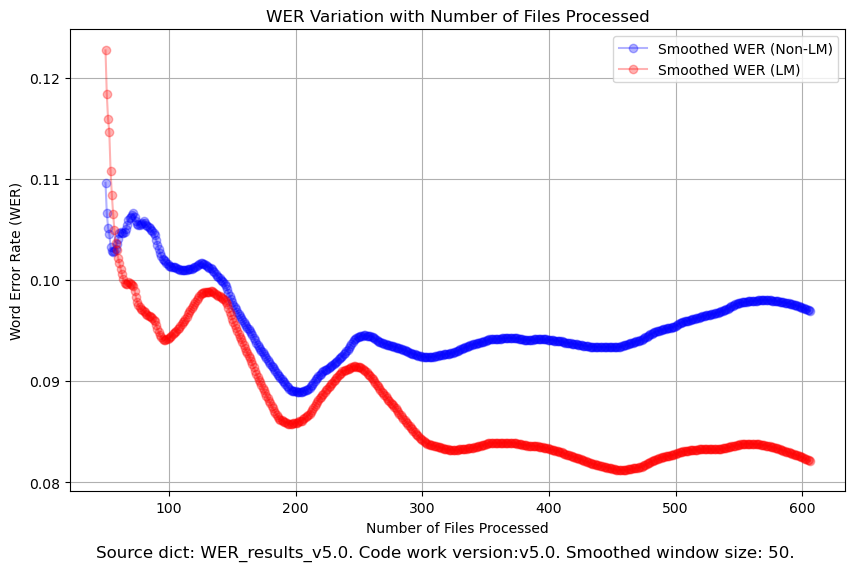

In [81]:
import matplotlib.pyplot as plt
import numpy as np

# Initialize lists to store the number of files processed and the corresponding WER values for both models
num_files_processed = []
wer_values_non_lm = []
wer_values_lm = []

# Iterate over the number of files processed
for i in range(1, len(WER_results) + 1):
    # Initialize variables to accumulate totals for both models
    overall_total_asr_deletions_non_lm = 0
    overall_total_asr_additions_non_lm = 0
    overall_total_asr_substitutions_non_lm = 0
    overall_total_tokens_non_lm = 0
    
    overall_total_asr_deletions_lm = 0
    overall_total_asr_additions_lm = 0
    overall_total_asr_substitutions_lm = 0
    
    # Calculate overall totals for both models for the first i files
    for result in WER_results[:i]:
        if isinstance(result, dict):
            overall_total_asr_deletions_non_lm += result.get("wer_deletions", 0)
            overall_total_asr_additions_non_lm += result.get("wer_additions", 0)
            overall_total_asr_substitutions_non_lm += result.get("wer_substitutions", 0)
            overall_total_tokens_non_lm += result.get("wer_tokens", 0)
            
            overall_total_asr_deletions_lm += result.get("wer_deletions_lm", 0)
            overall_total_asr_additions_lm += result.get("wer_additions_lm", 0)
            overall_total_asr_substitutions_lm += result.get("wer_substitutions_lm", 0)
    
    # Calculate WER for both models
    if overall_total_tokens_non_lm > 0:
        wer_non_lm = (overall_total_asr_deletions_non_lm + overall_total_asr_additions_non_lm + overall_total_asr_substitutions_non_lm) / overall_total_tokens_non_lm
    else:
        wer_non_lm = 0
    
    if overall_total_tokens_non_lm > 0:
        wer_lm = (overall_total_asr_deletions_lm + overall_total_asr_additions_lm + overall_total_asr_substitutions_lm) / overall_total_tokens_non_lm
    else:
        wer_lm = 0
    
    # Append the number of files processed and the WER values to the lists
    num_files_processed.append(i)
    wer_values_non_lm.append(wer_non_lm)
    wer_values_lm.append(wer_lm)

# Define a function to calculate the moving average
def moving_average(values, window):
    weights = np.repeat(1.0, window) / window
    sma = np.convolve(values, weights, 'valid')
    return sma

# Calculate the moving average of the WER values for both models with a window size
window_size = 50  # Adjust this value as needed
smoothed_wer_values_non_lm = moving_average(wer_values_non_lm, window_size)
smoothed_wer_values_lm = moving_average(wer_values_lm, window_size)

# Adjust the num_files_processed to match the length of the smoothed WER values
adjusted_num_files_processed = num_files_processed[window_size-1:]

# Plot the WER values and the smoothed WER values for both models
plt.figure(figsize=(10, 6))
plt.plot(adjusted_num_files_processed, smoothed_wer_values_non_lm, marker='o', linestyle='-', color='b', alpha=0.3, label='Smoothed WER (Non-LM)')
plt.plot(adjusted_num_files_processed, smoothed_wer_values_lm, marker='o', linestyle='-', color='r', alpha=0.3, label='Smoothed WER (LM)')
plt.xlabel('Number of Files Processed')
plt.ylabel('Word Error Rate (WER)')
plt.title('WER Variation with Number of Files Processed')
plt.legend()
plt.grid(True)


# Add text at the bottom of the plot
wer_plot_from_version2 = wer_plot_from_version[:-4] + "png"

wer_plot_save = os.path.join(wer_plot_save_path, wer_plot_from_version2)

bottom_text = f"Source dict: {wer_plot_from_version[:-4]} Code work version:{work_version}. Smoothed window size: {window_size}."
plt.figtext(0.5, 0.001, bottom_text, wrap=True, horizontalalignment='center', fontsize=12)

plt.savefig(wer_plot_save, dpi=300, bbox_inches='tight')
print(f"Saving plot: {wer_plot_save}")

plt.show()

### CER Plotting

Saving plot: D:\ASR\ParlaspeechHR\CER_results_v5.0.png


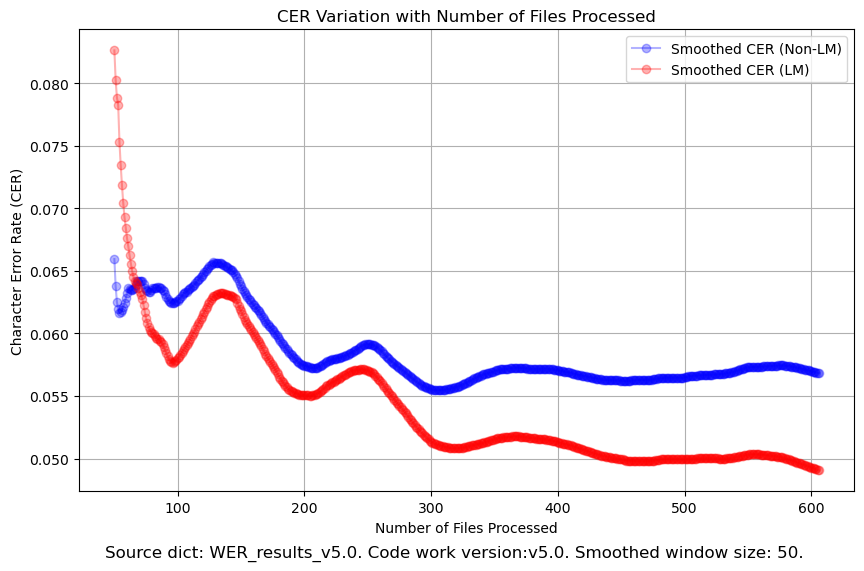

In [82]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Initialize lists to store the number of files processed and the corresponding CER values for both models
num_files_processed = []
cer_values_non_lm = []
cer_values_lm = []

# Iterate over the number of files processed
for i in range(1, len(WER_results) + 1):
    # Initialize variables to accumulate totals for both models
    overall_total_cer_deletions_non_lm = 0
    overall_total_cer_additions_non_lm = 0
    overall_total_cer_substitutions_non_lm = 0
    overall_total_cer_tokens_non_lm = 0
    
    overall_total_cer_deletions_lm = 0
    overall_total_cer_additions_lm = 0
    overall_total_cer_substitutions_lm = 0
    
    # Calculate overall totals for both models for the first i files
    for result in WER_results[:i]:
        if isinstance(result, dict):
            if result.get("cer_deletions") is not None:
                overall_total_cer_deletions_non_lm += result.get("cer_deletions", 0)
            if result.get("cer_additions") is not None:
                overall_total_cer_additions_non_lm += result.get("cer_additions", 0)
            if result.get("cer_substitutions") is not None:
                overall_total_cer_substitutions_non_lm += result.get("cer_substitutions", 0)
            overall_total_cer_tokens_non_lm += result.get("cer_tokens", 0)
            
            overall_total_cer_deletions_lm += result.get("cer_deletions_lm", 0)
            overall_total_cer_additions_lm += result.get("cer_additions_lm", 0)
            overall_total_cer_substitutions_lm += result.get("cer_substitutions_lm", 0)
    
    # Calculate CER for both models
    if overall_total_cer_tokens_non_lm > 0:
        cer_non_lm = (overall_total_cer_deletions_non_lm + overall_total_cer_additions_non_lm + overall_total_cer_substitutions_non_lm) / overall_total_cer_tokens_non_lm
    else:
        cer_non_lm = 0
    
    if overall_total_cer_tokens_non_lm > 0:
        cer_lm = (overall_total_cer_deletions_lm + overall_total_cer_additions_lm + overall_total_cer_substitutions_lm) / overall_total_cer_tokens_non_lm
    else:
        cer_lm = 0
    
    # Append the number of files processed and the CER values to the lists
    num_files_processed.append(i)
    cer_values_non_lm.append(cer_non_lm)
    cer_values_lm.append(cer_lm)

# Define a function to calculate the moving average
def moving_average(values, window):
    weights = np.repeat(1.0, window) / window
    sma = np.convolve(values, weights, 'valid')
    return sma

# Calculate the moving average of the CER values for both models with a window size
#window_size = 10  # Adjust this value as needed
smoothed_cer_values_non_lm = moving_average(cer_values_non_lm, window_size)
smoothed_cer_values_lm = moving_average(cer_values_lm, window_size)

# Adjust the num_files_processed to match the length of the smoothed CER values
adjusted_num_files_processed = num_files_processed[window_size-1:]

# Plot the CER values and the smoothed CER values for both models
plt.figure(figsize=(10, 6))
plt.plot(adjusted_num_files_processed, smoothed_cer_values_non_lm, marker='o', linestyle='-', color='b', alpha=0.3, label='Smoothed CER (Non-LM)')
plt.plot(adjusted_num_files_processed, smoothed_cer_values_lm, marker='o', linestyle='-', color='r', alpha=0.3, label='Smoothed CER (LM)')
plt.xlabel('Number of Files Processed')
plt.ylabel('Character Error Rate (CER)')
plt.title('CER Variation with Number of Files Processed')
plt.legend()
plt.grid(True)

# Add text at the bottom of the plot
cer_plot_from_version2 = "CER" + cer_plot_from_version[3:-4] + "png"
cer_plot_save = os.path.join(cer_plot_save_path, cer_plot_from_version2)

bottom_text = f"Source dict: {cer_plot_from_version[:-4]} Code work version:{work_version}. Smoothed window size: {window_size}."
plt.figtext(0.5, 0.001, bottom_text, wrap=True, horizontalalignment='center', fontsize=12)

plt.savefig(cer_plot_save, dpi=300, bbox_inches='tight')
print(f"Saving plot: {cer_plot_save}")

plt.show()


## Sample size? Statistical Nightmare

In [67]:
pip show statsmodels

Note: you may need to restart the kernel to use updated packages.


### NEW STATS

In [70]:
%%time

import numpy as np
import matplotlib.pyplot as plt
from statsmodels.stats.power import TTestIndPower

# Load the text data
def load_text_data(file_path):
    with open(file_path, 'r') as file:
        sentences = file.readlines()
    sentences = [sentence.strip() for sentence in sentences]
    return sentences

# Compute WER and CER (dummy function, replace with actual calculation)
def compute_wer_cer(sentences):
    wer_tokens = np.random.normal(loc=10, scale=2, size=len(sentences))  # Replace with actual WER calculation
    cer_tokens = np.random.normal(loc=5, scale=1, size=len(sentences))   # Replace with actual CER calculation
    return wer_tokens, cer_tokens

# Estimate sample size for a two-sample t-test
def estimate_sample_size(effect_size, alpha=0.05, power=0.8):
    analysis = TTestIndPower()
    sample_size = analysis.solve_power(effect_size=effect_size, alpha=alpha, power=power)
    return int(np.ceil(sample_size))

# Load data
file_path_sens = r"D:\ParlaSpeech-HR.v1.0\kenlm_lmplz_to_arpa_v4.4.txt"
sentences = load_text_data(file_path_sens)

# Compute WER and CER
wer_tokens, cer_tokens = compute_wer_cer(file_path_sens)

print(f"Loaded data from:\n {file_path_sens}")

ModuleNotFoundError: No module named 'statsmodels'

In [ ]:
print(wer_tokens, cer_tokens)

In [ ]:
# Calculate descriptive statistics
wer_mean = np.mean(wer_tokens)
wer_std = np.std(wer_tokens)
cer_mean = np.mean(cer_tokens)
cer_std = np.std(cer_tokens)

# Print summary statistics
print(f"WER - Mean: {wer_mean:.2f}, Std: {wer_std:.2f}")
print(f"CER - Mean: {cer_mean:.2f}, Std: {cer_std:.2f}")

# Estimate the sample size needed
# Assuming a medium effect size (Cohen's d = 0.5) for WER and CER
wer_effect_size = 0.5  # Adjust based on your specific scenario
cer_effect_size = 0.5  # Adjust based on your specific scenario

wer_sample_size = estimate_sample_size(effect_size=wer_effect_size)
cer_sample_size = estimate_sample_size(effect_size=cer_effect_size)

print(f"Estimated sample size for WER: {wer_sample_size}")
print(f"Estimated sample size for CER: {cer_sample_size}")

# Create histograms to visualize distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(wer_tokens, bins=50, edgecolor='black')
plt.title('Histogram of WER Tokens')
plt.xlabel('WER Tokens')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(cer_tokens, bins=50, edgecolor='black')
plt.title('Histogram of CER Tokens')
plt.xlabel('CER Tokens')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


### OLD STATS

In [66]:
import statsmodels.stats.api as sms

# Define parameters for sample size calculation
effect_size = 0.5  # Expected effect size (difference in means divided by standard deviation)
alpha = 0.001  # Significance level (typically 0.05 or 0.01 for 95% or 99% confidence)
power = 0.9 # Desired statistical power (typically 0.8 or 0.9)

# Calculate sample size for each group (assuming equal sample sizes for simplicity)
total_population = 403925  # Total population size
sample_size_needed = sms.tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, ratio=1.0, alternative='two-sided')

# Print the calculated sample size
print(f"Required sample size per group: {sample_size_needed:.0f}")

# Calculate how many groups you can sample from total population
# For simplicity, assuming that you have a large enough population to draw multiple samples
num_groups = total_population / sample_size_needed

# Print the number of groups
print(f"Number of groups you can sample: {num_groups:.0f}")


ModuleNotFoundError: No module named 'statsmodels'

In [68]:
import scipy.stats as stats

# Define parameters
sample_size = 600
sigma = 10  # Estimated standard deviation
confidence_level = 0.99  # 95% confidence level

# Find the z-score for the desired confidence level
z = stats.norm.ppf((1 + confidence_level) / 2)  # For a two-tailed test

# Calculate the margin of error (MOE)
MOE = z * (sigma / (sample_size ** 0.5))

# Calculate the confidence interval (CI)
mean_estimate = 0  # Replace with your mean estimate if known
CI_low = mean_estimate - MOE
CI_high = mean_estimate + MOE

# Print results
print(f"Sample Size: {sample_size}")
print(f"Estimated Standard Deviation (sigma): {sigma}")
print(f"Confidence Interval (CI) for {confidence_level * 100}% confidence level: [{CI_low:.4f}, {CI_high:.4f}]")


Sample Size: 600
Estimated Standard Deviation (sigma): 10
Confidence Interval (CI) for 99.0% confidence level: [-1.0516, 1.0516]


WER - Mean: 36.61, Std: 13.32
CER - Mean: 186.10, Std: 64.96


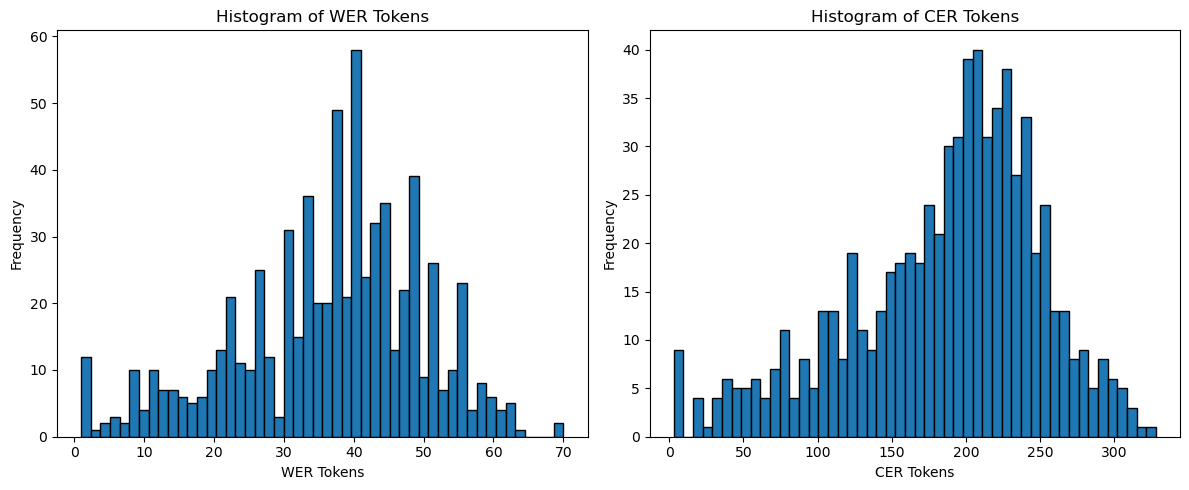

In [176]:
import numpy as np
import matplotlib.pyplot as plt

# Extract WER and CER metrics into lists
wer_tokens = [result["wer_tokens"] for result in WER_results]
cer_tokens = [result["cer_tokens"] for result in WER_results]

# Calculate descriptive statistics
wer_mean = np.mean(wer_tokens)
wer_std = np.std(wer_tokens)
cer_mean = np.mean(cer_tokens)
cer_std = np.std(cer_tokens)

# Print summary statistics
print(f"WER - Mean: {wer_mean:.2f}, Std: {wer_std:.2f}")
print(f"CER - Mean: {cer_mean:.2f}, Std: {cer_std:.2f}")

# Create histograms to visualize distribution
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(wer_tokens, bins=50, edgecolor='black')
plt.title('Histogram of WER Tokens')
plt.xlabel('WER Tokens')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(cer_tokens, bins=50, edgecolor='black')
plt.title('Histogram of CER Tokens')
plt.xlabel('CER Tokens')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [161]:
import numpy as np
from scipy.stats import ttest_ind, f_oneway
import statsmodels.stats.api as sms# Assuming results_list is your list of dictionaries with the relevant data

wer_non_lm = []
wer_lm = []
cer_non_lm = []
cer_lm = []

for result in WER_results:
    wer_rate = (result["wer_deletions"] + result["wer_additions"] + result["wer_substitutions"]) / result["wer_tokens"] if result["wer_tokens"] > 0 else 0
    wer_rate_lm = (result["wer_deletions_lm"] + result["wer_additions_lm"] + result["wer_substitutions_lm"]) / result["wer_tokens"] if result["wer_tokens"] > 0 else 0

    cer_rate = (result["cer_deletions"] + result["cer_additions"] + result["cer_substitutions"]) / result["cer_tokens"] if result["cer_tokens"] > 0 else 0
    cer_rate_lm = (result["cer_deletions_lm"] + result["cer_additions_lm"] + result["cer_substitutions_lm"]) / result["cer_tokens"] if result["cer_tokens"] > 0 else 0

    wer_non_lm.append(wer_rate)
    wer_lm.append(wer_rate_lm)
    cer_non_lm.append(cer_rate)
    cer_lm.append(cer_rate_lm)

# Print the calculated WER and CER rates for non-LM and LM
# print(f"WER rates (Non-LM): {wer_non_lm}")
# print(f"WER rates (LM): {wer_lm}")
# print(f"CER rates (Non-LM): {cer_non_lm}")
# print(f"CER rates (LM): {cer_lm}")

In [169]:
# Calculate confidence intervals
def confidence_interval(data, confidence=0.95):
    n = len(data)
    mean = np.mean(data)
    sem = stats.sem(data)
    h = sem * stats.t.ppf((1 + confidence) / 2, n - 1)
    return mean, mean - h, mean + h

wer_non_lm_ci = confidence_interval(wer_non_lm)
wer_lm_ci = confidence_interval(wer_lm)
cer_non_lm_ci = confidence_interval(cer_non_lm)
cer_lm_ci = confidence_interval(cer_lm)

print(f"WER Non-LM: Mean={wer_non_lm_ci[0]:.4f}, CI=({wer_non_lm_ci[1]:.4f}, {wer_non_lm_ci[2]:.4f})")
print(f"WER LM: Mean={wer_lm_ci[0]:.4f}, CI=({wer_lm_ci[1]:.4f}, {wer_lm_ci[2]:.4f})")
print(f"CER Non-LM: Mean={cer_non_lm_ci[0]:.4f}, CI=({cer_non_lm_ci[1]:.4f}, {cer_non_lm_ci[2]:.4f})")
print(f"CER LM: Mean={cer_lm_ci[0]:.4f}, CI=({cer_lm_ci[1]:.4f}, {cer_lm_ci[2]:.4f})")

WER Non-LM: Mean=0.0834, CI=(0.0749, 0.0919)
WER LM: Mean=0.1655, CI=(0.1521, 0.1790)
CER Non-LM: Mean=0.0495, CI=(0.0439, 0.0550)
CER LM: Mean=0.1056, CI=(0.0964, 0.1148)


In [171]:
import scipy.stats as stats

# Calculate Pearson's correlation coefficient for WER and CER rates
correlation_wer_non_lm, p_value_wer_non_lm = stats.pearsonr(wer_non_lm, cer_non_lm)
correlation_wer_lm, p_value_wer_lm = stats.pearsonr(wer_lm, cer_lm)

print(f"Pearson's correlation coefficient between WER and CER rates for Non-LM: {correlation_wer_non_lm:.2f}")
print(f"P-value: {p_value_wer_non_lm:.4f}\n")

print(f"Pearson's correlation coefficient between WER and CER rates for LM: {correlation_wer_lm:.2f}")
print(f"P-value: {p_value_wer_lm:.4f}")


Pearson's correlation coefficient between WER and CER rates for Non-LM: 0.92
P-value: 0.0000

Pearson's correlation coefficient between WER and CER rates for LM: 0.95
P-value: 0.0000


In [162]:
# Perform t-tests for WER
wer_t_stat, wer_p_value = ttest_ind(wer_non_lm, wer_lm)
print(f"WER T-test: t-statistic = {wer_t_stat:.3f}, p-value = {wer_p_value:.3f}")

# Perform t-tests for CER
cer_t_stat, cer_p_value = ttest_ind(cer_non_lm, cer_lm)
print(f"CER T-test: t-statistic = {cer_t_stat:.3f}, p-value = {cer_p_value:.3f}")


WER T-test: t-statistic = -10.139, p-value = 0.000
CER T-test: t-statistic = -10.264, p-value = 0.000


In [163]:
# Assuming you have more groups, for example:
wer_group1 = wer_non_lm
wer_group2 = wer_lm
# Add other groups if needed

# Perform ANOVA for WER
wer_f_stat, wer_p_value = f_oneway(wer_group1, wer_group2)
print(f"WER ANOVA: F-statistic = {wer_f_stat:.3f}, p-value = {wer_p_value:.3f}")

# Assuming you have more groups, for example:
cer_group1 = cer_non_lm
cer_group2 = cer_lm
# Add other groups if needed

# Perform ANOVA for CER
cer_f_stat, cer_p_value = f_oneway(cer_group1, cer_group2)
print(f"CER ANOVA: F-statistic = {cer_f_stat:.3f}, p-value = {cer_p_value:.3f}")


WER ANOVA: F-statistic = 102.792, p-value = 0.000
CER ANOVA: F-statistic = 105.346, p-value = 0.000


In [164]:
# Define the sample size you can afford
sample_size = 600  # Your actual sample size

# Calculate the confidence interval for WER
wer_conf_interval = sms.DescrStatsW(wer_non_lm[:sample_size]).tconfint_mean()
print(f"WER Confidence Interval: {wer_conf_interval}")

# Calculate the confidence interval for CER
cer_conf_interval = sms.DescrStatsW(cer_non_lm[:sample_size]).tconfint_mean()
print(f"CER Confidence Interval: {cer_conf_interval}")


WER Confidence Interval: (0.07344274844841658, 0.09210594100831151)
CER Confidence Interval: (0.04328806886773624, 0.05547488908062649)


In [168]:
import statsmodels.stats.api as sms

# Define the parameters for the sample size calculation
effect_size = 0.1  # This is a commonly used medium effect size
alpha = 0.05  # Significance level
power = 0.8  # Desired statistical power

# Calculate the sample size needed for the given effect size, alpha, and power
sample_size_needed = sms.tt_ind_solve_power(effect_size=effect_size, alpha=alpha, power=power, ratio=1.0, alternative='two-sided')

print(f"Required sample size per group for effect size {effect_size}: {sample_size_needed:.0f}")

# Check if the sample size of 600 is adequate for the given power and effect size
power_given_sample_size = sms.tt_ind_solve_power(effect_size=effect_size, alpha=alpha, nobs1=600, ratio=1.0, alternative='two-sided')

print(f"Power with sample size of 600: {power_given_sample_size:.4f}")


Required sample size per group for effect size 0.1: 1571
Power with sample size of 600: 0.4094


# x scrap later

# Log info